In [1]:
import tensorflow as tf
import numpy as np

In [2]:
HISTORY_TIMES = [4, 8, 16, 32, 48, 64, 96, 128]

PIECES = 256

ADDITIONAL_INPUT_SIZE = 6

In [45]:
tf.reset_default_graph()

# Training Parameters
learning_rate = tf.constant(0.001, dtype=tf.float32)
batch_size = 80
voices = 5
epsilon = 1e-06

# Network Parameters
num_input = 12 + ADDITIONAL_INPUT_SIZE      # dimension of one input at moment
num_hidden_local = 100
num_hidden_read = 100
num_hidden_aggreg = 100
num_hidden_voicegen = 100
num_output = 12      # output dimension
num_hidden_decoder = 100
num_decoder_output = 88

# tf graph input
X = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, num_input])
History = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, len(HISTORY_TIMES), num_output])

with tf.variable_scope("local"):
    local_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_local, forget_bias=1.0)])
    local_lstm_outputs, _ = tf.nn.dynamic_rnn(local_lstm, X[:, :-1], dtype=tf.float32)

with tf.variable_scope("global"):
    read_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_read, forget_bias=1.0, use_peepholes=True)])
    read_lstm_outputs, _ = tf.nn.dynamic_rnn(read_lstm, 
                tf.concat([X[:, :-1], tf.reshape(History[:, :-1], [batch_size, -1, len(HISTORY_TIMES) * num_output])], axis=2), 
                                             dtype=tf.float32)
read_index = tf.nn.softmax(tf.layers.dense(read_lstm_outputs, len(HISTORY_TIMES), activation=None))
read = tf.reduce_mean(tf.expand_dims(read_index, 3) * History[:, 1:], axis=2)

with tf.variable_scope("aggreg"):
    aggreg_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_aggreg, forget_bias=1.0)])
    aggreg_lstm_outputs, _ = tf.nn.dynamic_rnn(aggreg_lstm, tf.concat([read, local_lstm_outputs], axis=2), dtype=tf.float32)

# сюда будем складывать вероятности, с которым генерится каждый голос
voices_proba = []
# сюда сложим итоговую вероятность, с которой каждая нота хоть раз засэмплировалась, для сравнения с истиной в Loss-е
p = tf.zeros([batch_size, tf.shape(X)[1] - 1, num_output], dtype=tf.float32)
ban_p = tf.zeros([batch_size, tf.shape(X)[1] - 1, num_output], dtype=tf.float32)
# вспомогательный расчёт (1 - p1)(1 - p2)...
neg_p = tf.ones([batch_size, tf.shape(X)[1] - 1, num_output], dtype=tf.float32)
ban_neg_p = tf.ones([batch_size, tf.shape(X)[1] - 1, num_output], dtype=tf.float32)

# если этот флаг true, то на вход уже даны результаты сэмплирования из распределений голосов в truly_sampled_notes
was_sampled_notes_given = tf.placeholder(tf.bool)
truly_sampled_notes = tf.zeros([voices, batch_size, tf.shape(X)[1] - 2, num_output*2], dtype=tf.float32)
# сюда для удобства складываем то, что сэмплируется для каждого голоса
sampled_notes_by_voices = []
# результат сэмплирования (просто объединение элементов sampled_notes_by_voices)
sampled_notes = tf.zeros([batch_size, tf.shape(X)[1] - 1, num_output], dtype=tf.float32)
banned_notes = tf.zeros([batch_size, tf.shape(X)[1] - 1, num_output], dtype=tf.float32)

loss_op = tf.Variable(0.0, dtype=tf.float32)
voice_losses = []

voicegen_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_voicegen, forget_bias=1.0)])
for v in range(voices):
    # пихаем в персональный микролстм       
    voicegen_lstm_outputs, _ = tf.nn.dynamic_rnn(voicegen_lstm, 
                                    tf.concat([aggreg_lstm_outputs, sampled_notes, banned_notes], axis=2), dtype=tf.float32)

    # зануляем вероятности тех нот, которые уже прозвучали или забанены, и о чём голос вапщета знал:
    coeff = 1 - tf.concat([sampled_notes, sampled_notes], axis=2)
    coeff *= 1 - tf.concat([banned_notes, banned_notes], axis=2)

    # линейно преобразуем к 13 числам и берём софтмакс. Это распределение, из которого надо сэмплировать очередную ноту        
    values = coeff * tf.exp(tf.layers.dense(voicegen_lstm_outputs, (num_output*2), activation=None))        
    voices_proba.append(values / tf.reduce_sum(values, axis=2)[:,:,None])
    
    # вероятность нот быть засэмплированными увеличивается на (1 - p_1)(1 - p_2)...(1 - p_(v-1))p_v
    p += neg_p * voices_proba[-1][:,:,:num_output]
    neg_p *= 1 - voices_proba[-1][:,:,:num_output]
    
    ban_p += ban_neg_p * voices_proba[-1][:,:,num_output:]
    ban_neg_p *= 1 - voices_proba[-1][:,:,num_output:]
    
    # зануляем те вероятности, которые, согласно правильному ответу, не могли засэмплироваться.
    #aposter = tf.where(tf.cast(tf.concat([X[:, 1:, :num_output], 1 - X[:, 1:, :num_output]], axis=2), tf.bool), 
    #                   voices_proba[-1], tf.zeros([batch_size, tf.shape(X)[1] - 1, num_output*2], dtype=tf.float32))
    
    # сэмплируем для каждого батча и момента времени (из-за этого понадобилось два решэйпа) и преобразуем в one-hot
    sampled = tf.one_hot(
            # tf.multinomial is not working with 2D-batches...
            tf.reshape(tf.multinomial(logits=tf.reshape(tf.log(voices_proba[-1]), [-1, num_output*2]), num_samples=1), 
                                       [batch_size, -1]), depth=num_output*2)
    
    # однако мы не хотим подавать в последующие голоса неверную информацию. Если wsng = False, надо подавать верную инфу.
    # какую ноту голос выбрал, неважно, важно, чтобы в следующий голос 0 или 1 пришла из данных.
    right_sampled = tf.where(tf.cast(tf.concat([X[:, 1:, :num_output], 1 - X[:, 1:, :num_output]], axis=2), tf.bool), 
                       sampled, tf.zeros([batch_size, tf.shape(X)[1] - 1, num_output*2], dtype=tf.float32))
    right_sampled += tf.where(tf.cast(tf.concat([X[:, 1:, :num_output], 1 - X[:, 1:, :num_output]], axis=2), tf.bool), 
                     tf.concat([sampled[:, :, num_output:], sampled[:, :, :num_output]], axis=2), 
                     tf.zeros([batch_size, tf.shape(X)[1] - 1, num_output*2], dtype=tf.float32))
    
    # мы либо знаем, какая нота сгенерилась в этом голосе, по входу, либо берём те, что сгенерировались сейчас
    sampled_notes_by_voices.append(tf.cond(was_sampled_notes_given, 
                                           lambda: tf.concat([truly_sampled_notes[v], sampled[:, -1:]], axis=1), 
                                           lambda: right_sampled))
    
    # итого мы засэмплировали ноту, если засэмплировали её раньше, или засэмплировали сейчас.
    sampled_notes = tf.stop_gradient(tf.where(tf.cast(sampled_notes, tf.bool), sampled_notes, sampled_notes_by_voices[-1][:, :, :num_output]))
    banned_notes = tf.stop_gradient(tf.where(tf.cast(banned_notes, tf.bool), banned_notes, sampled_notes_by_voices[-1][:, :, num_output:]))
                             
clip_p = tf.clip_by_value(p*(1-ban_p), epsilon, 1 - epsilon)
ce = -tf.log(clip_p) * X[:, 1:, :num_output] - tf.log(1 - clip_p) * (1 - X[:, 1:, :num_output])
loss_op += tf.reduce_mean(ce)

# DECODER-------------------------

DecodedX = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, num_decoder_output])
DecoderInput = tf.concat([DecodedX[:, :-1], X[:, 1:, -ADDITIONAL_INPUT_SIZE:],
                          tf.cond(was_sampled_notes_given, lambda: sampled_notes, lambda: X[:, 1:, :-ADDITIONAL_INPUT_SIZE])], axis=2)
with tf.variable_scope("decoder"):
    decoder_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_decoder, forget_bias=1.0)])
    decoder_lstm_outputs, _ = tf.nn.dynamic_rnn(decoder_lstm, tf.concat([DecodedX[:, :-1], X[:, 1:]], axis=2), dtype=tf.float32)

decoder_p = tf.layers.dense(decoder_lstm_outputs, num_decoder_output, activation=None)

decoder_ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=decoder_p, labels=DecodedX[:, 1:])
loss_op += tf.reduce_mean(decoder_ce * 
            tf.tile(tf.cond(was_sampled_notes_given, lambda: sampled_notes, lambda: X[:, 1:, :-ADDITIONAL_INPUT_SIZE]), [1,1,8])[:,:,:num_decoder_output])
    
# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
gvs = optimizer.compute_gradients(loss_op)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)

#optimizing
#train_op = tf.contrib.layers.optimize_loss(
#                loss_op, tf.train.get_global_step(), optimizer=optimizer, learning_rate=learning_rate)

init = tf.global_variables_initializer()

In [46]:
# Start training
config = tf.ConfigProto(log_device_placement=True)  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.6  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)
sess = tf.Session(config = config)
saver = tf.train.Saver()

In [47]:
# Run the initializer
sess.run(init)

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def drawNotes(song, name="", scale=(None, None)):
    if scale[0] is None:
        scale = (song.shape[0] / 10, song.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(name)
    plt.imshow(song.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.shape[0], 4))
    plt.show()

In [25]:
songs = np.load("CP_dataset.npy")

In [26]:
import itertools
times = [np.array(t) for t in itertools.product([0, 1], repeat=ADDITIONAL_INPUT_SIZE)]*1000

In [27]:
def transform(song, stack_zeros=True):    
    wh = song[:, :12]
    for i in range(1,7):
        wh = np.logical_or(wh, song[:, 12*i:12*i+12])
    
    temp = wh.copy()
    for t in HISTORY_TIMES:
        h = np.roll(temp, t, axis=0)
        h[:t] = 0
        wh = np.concatenate([wh, h], axis=1)
          
    wh = np.concatenate([wh, times[:song.shape[0]]], axis=1)
            
    return wh

hsongs = []
decoded = []
for song in songs:
    t = transform(song)
    for i in range(0, t.shape[0] - PIECES, 32):
        hsongs.append(t[i:i+PIECES])
        decoded.append(song[i:i+PIECES])
hsongs = np.array(hsongs)
decoded = np.array(decoded)

In [28]:
def generateBatch():
    indexes = np.random.choice(np.arange(len(hsongs)), batch_size)
    batch, decoded_batch = hsongs[indexes], decoded[indexes]    
    tbatch = batch[:, :, :-ADDITIONAL_INPUT_SIZE].reshape((batch_size, PIECES, -1, 12))
    to_roll = np.random.randint(-6, 6)
    if to_roll > 0:
        decoded_batch[:, :, -to_roll:] = 0
    else:
        decoded_batch[:, :, :-to_roll] = 0
    tbatch = np.roll(tbatch, to_roll, axis=3)
    decoded_batch = np.roll(decoded_batch, to_roll, axis=2)
    ans = np.concatenate([tbatch.reshape((batch_size, PIECES, -1)), batch[:, :, -ADDITIONAL_INPUT_SIZE:]], axis=2)
    return (np.concatenate([ans[:, :, :12], ans[:, :, -ADDITIONAL_INPUT_SIZE:]], axis=2), 
            ans[:, :, 12:-ADDITIONAL_INPUT_SIZE].reshape(batch_size, PIECES, len(HISTORY_TIMES), 12), decoded_batch)

In [48]:
saver.restore(sess, "./tmp/100-100-100 HistoryUserScheme HAI LSTM collapsed CP_dataset 8-history 6-times 100-LSTMconditional banning no aposter 100-decoder lr=0.01.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/100-100-100 HistoryUserScheme HAI LSTM collapsed CP_dataset 8-history 6-times 100-LSTMconditional banning no aposter 100-decoder lr=0.01.ckpt


0.133096  mean for last:  0.134306


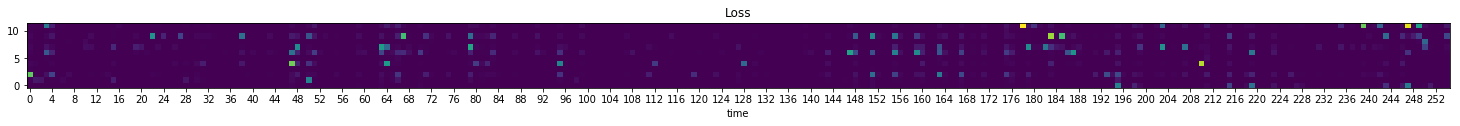

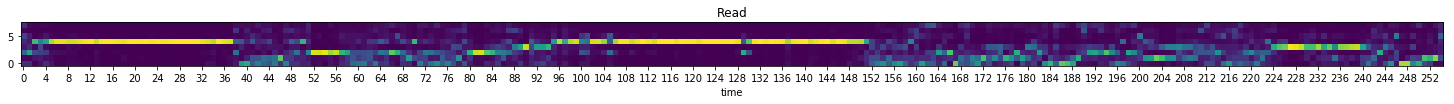

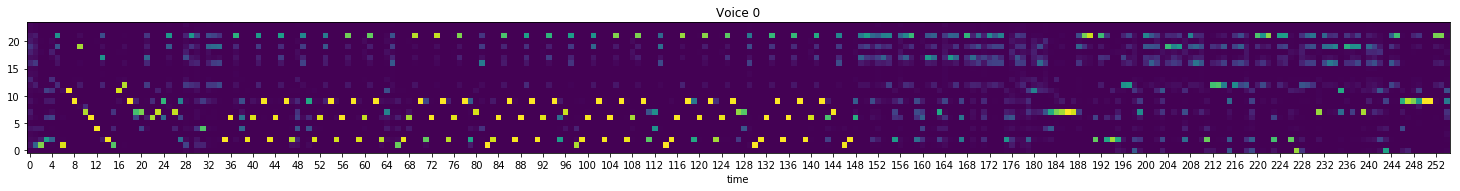

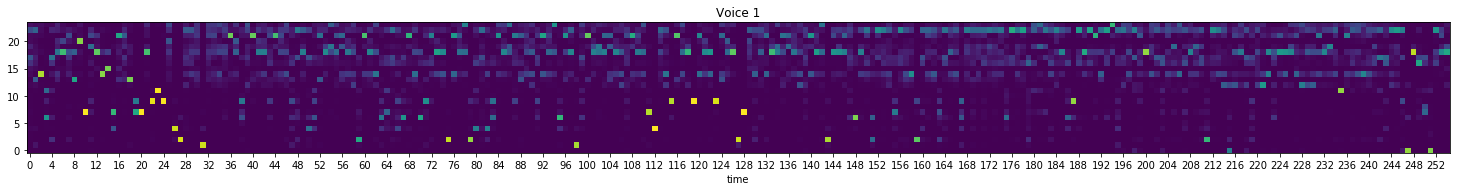

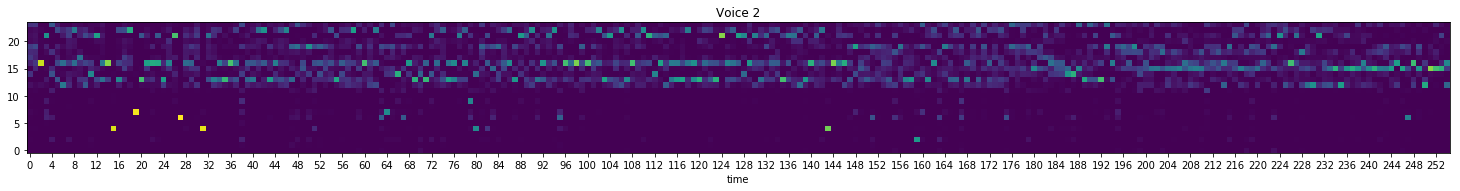

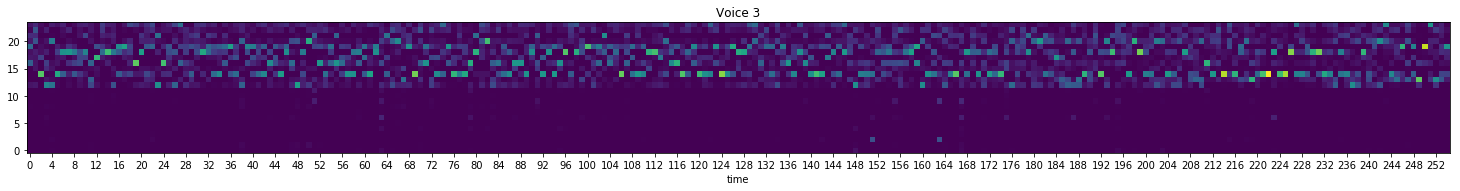

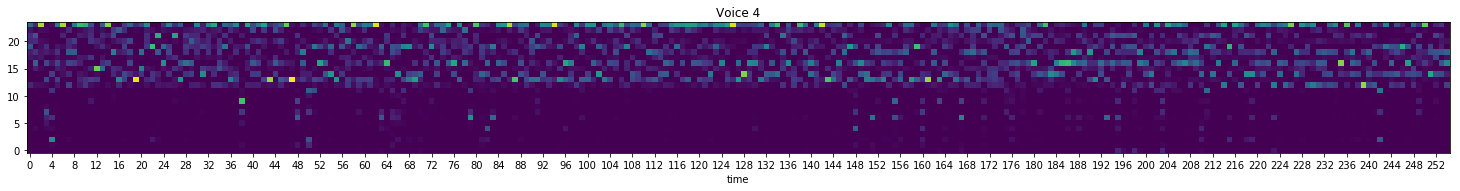

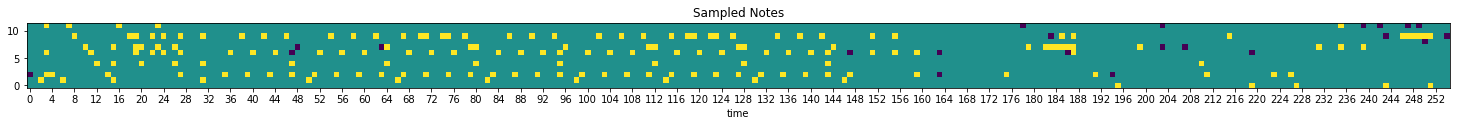

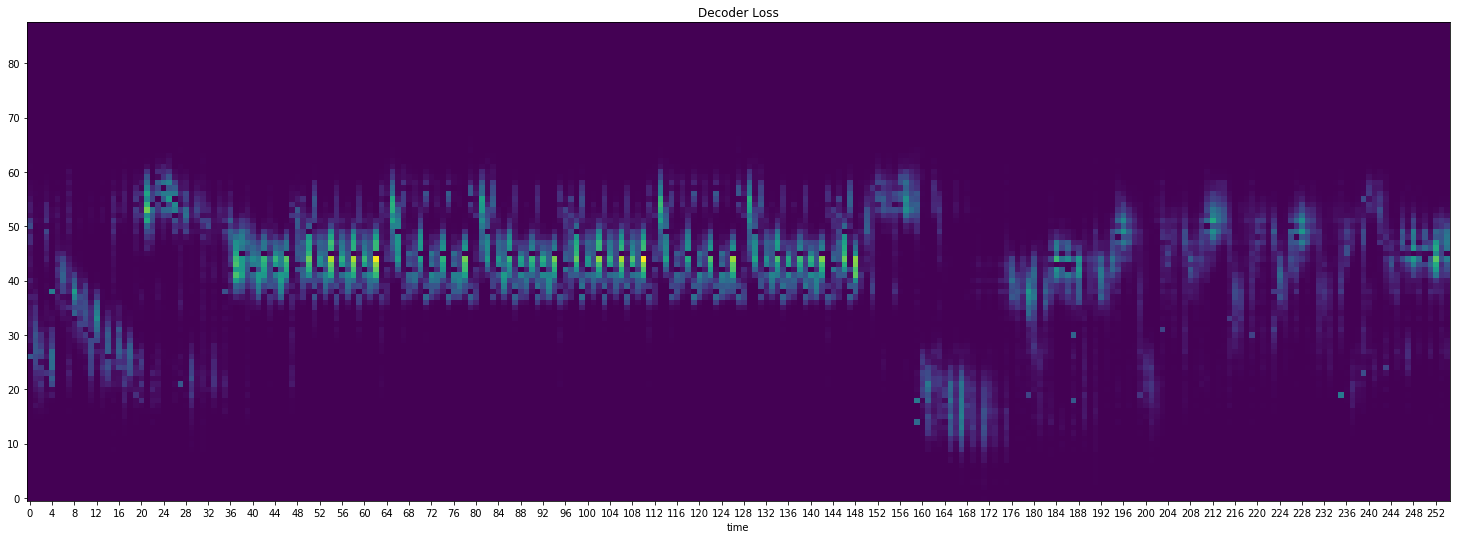

0.126313  mean for last:  0.133553


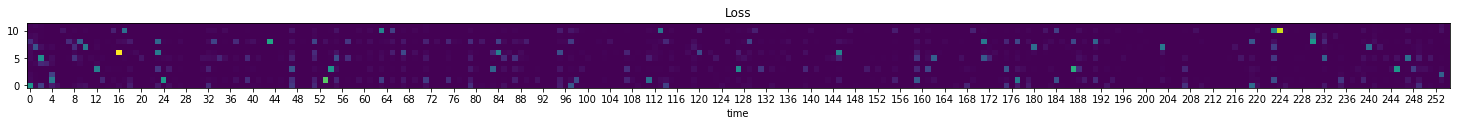

0.129194  mean for last:  0.132164


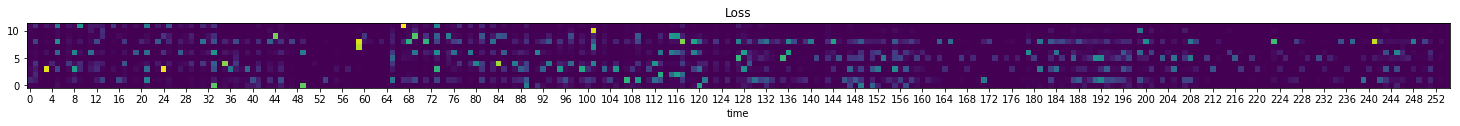

0.12734  mean for last:  0.131308


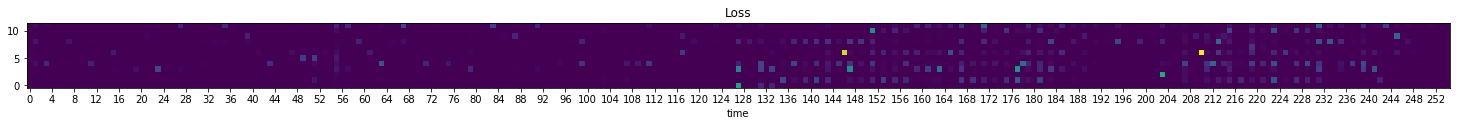

0.131048  mean for last:  0.130655


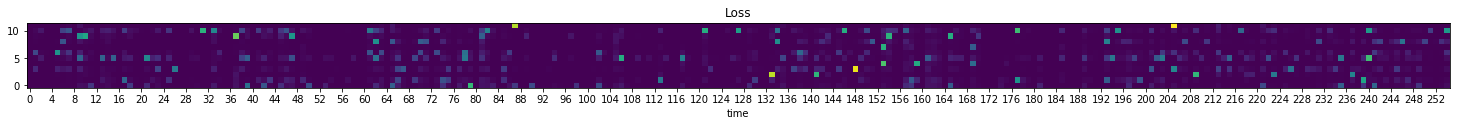

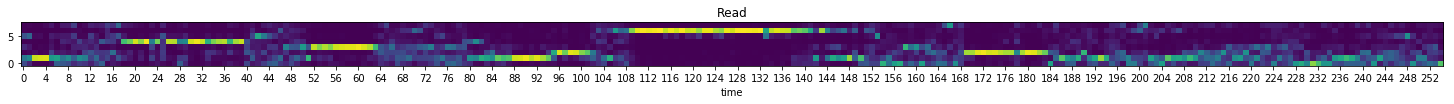

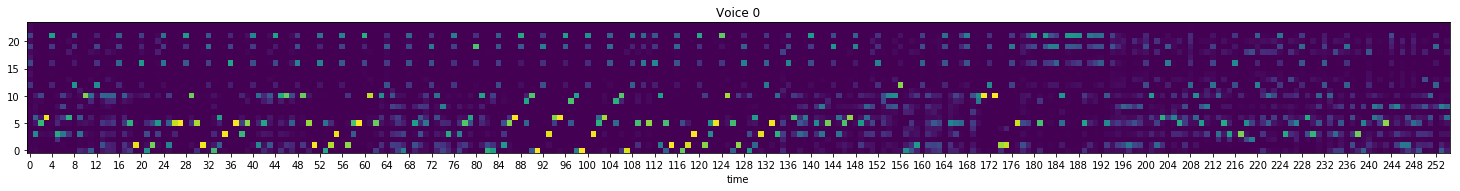

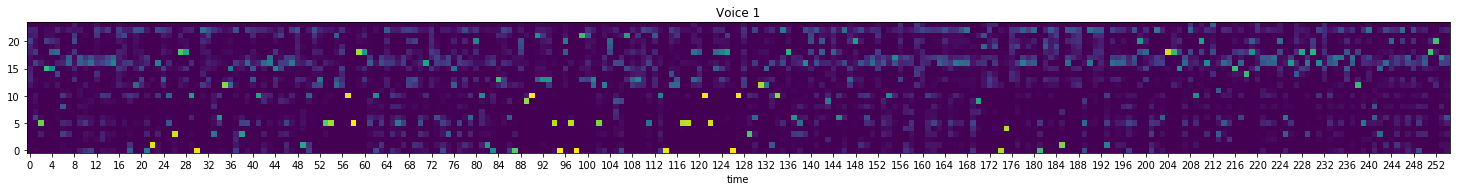

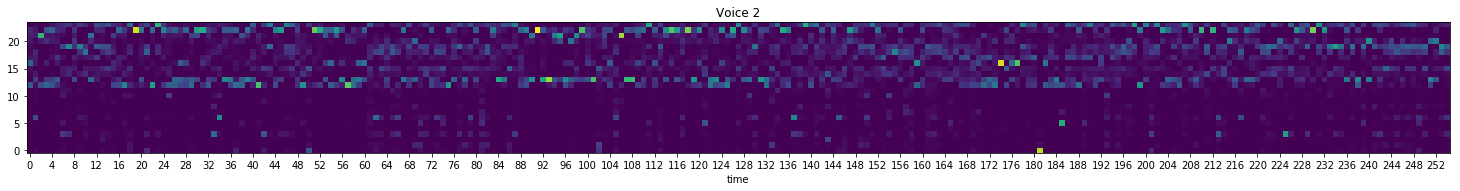

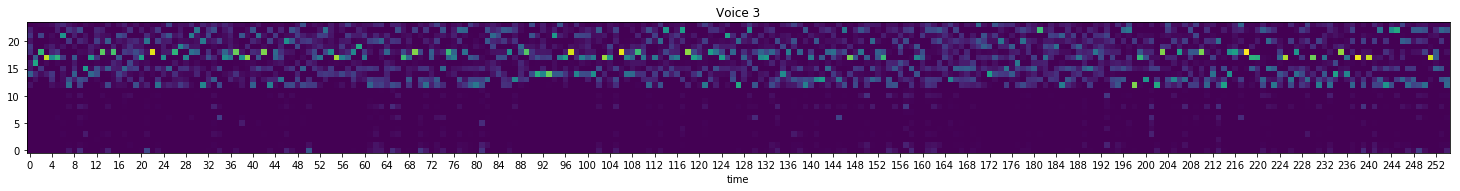

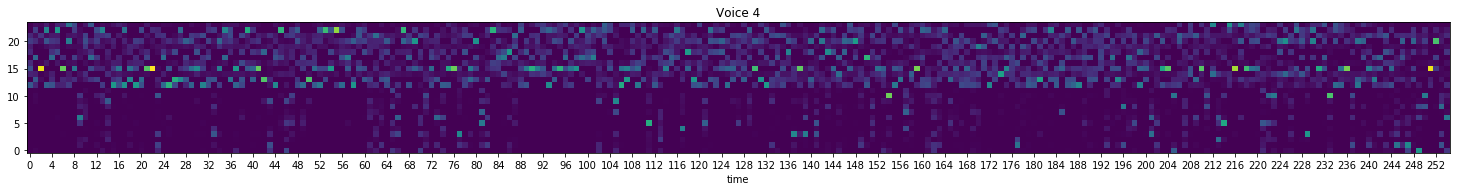

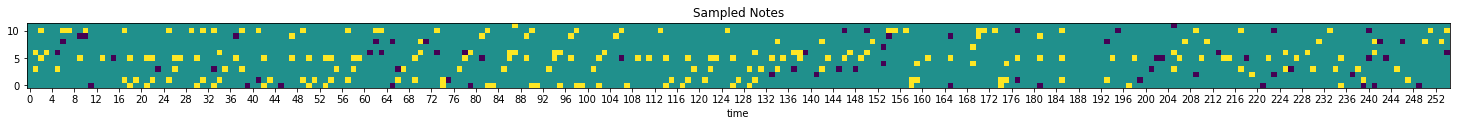

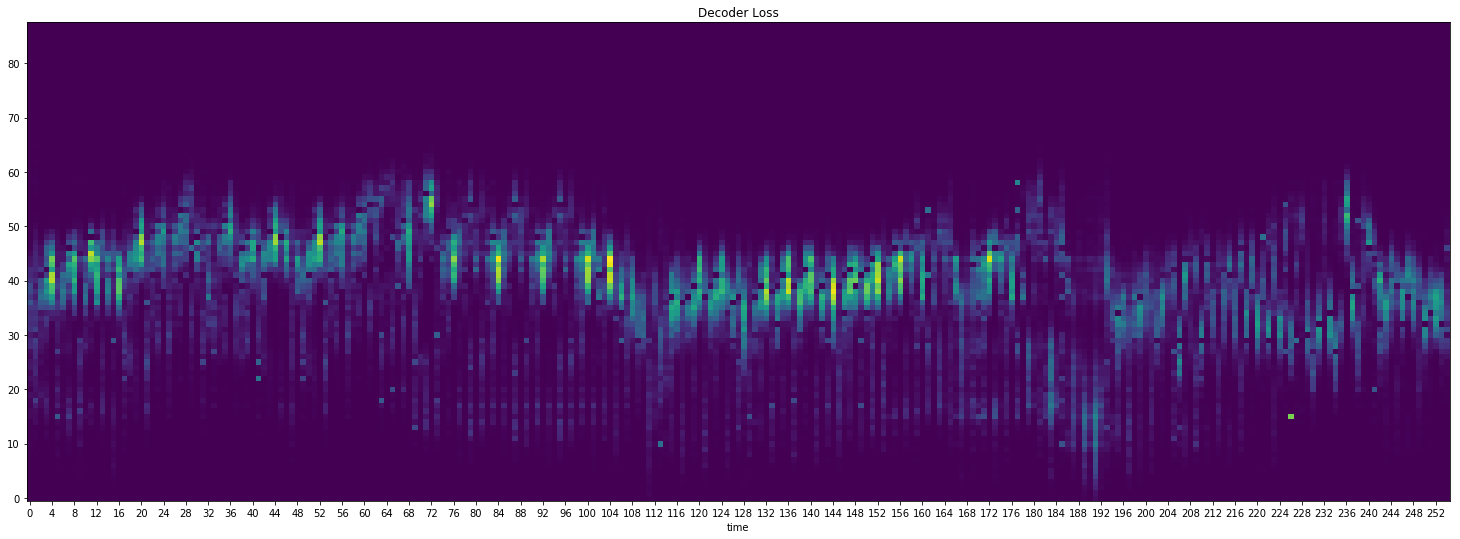

0.135924  mean for last:  0.129874


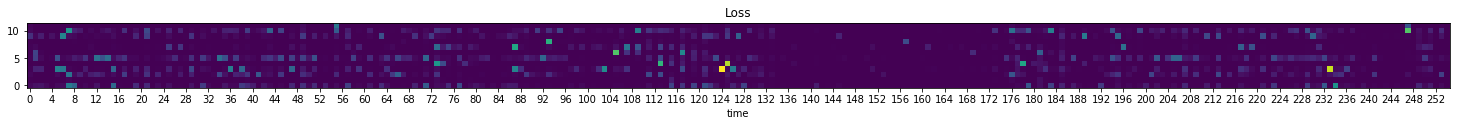

0.129455  mean for last:  0.128595


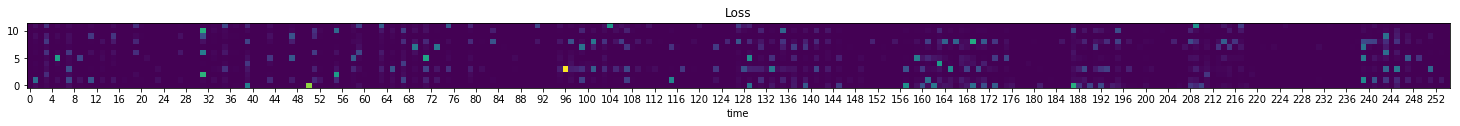

0.134131  mean for last:  0.129602


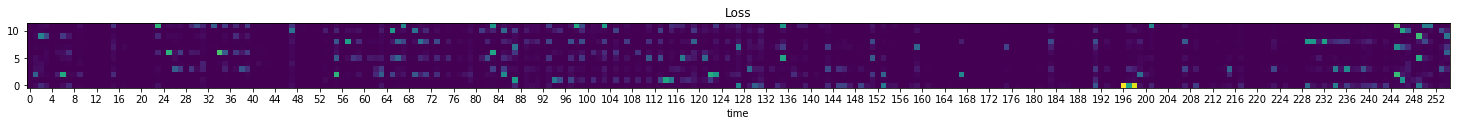

0.122524  mean for last:  0.127914


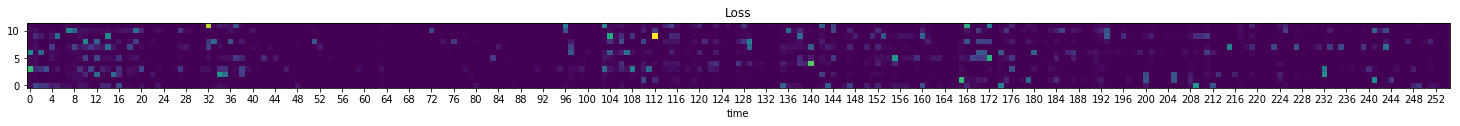

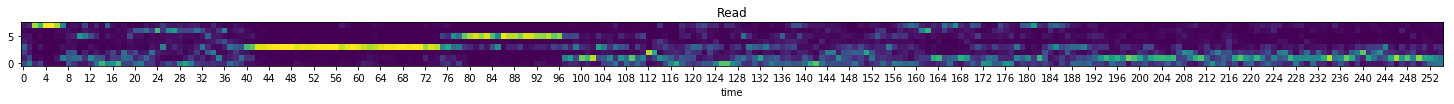

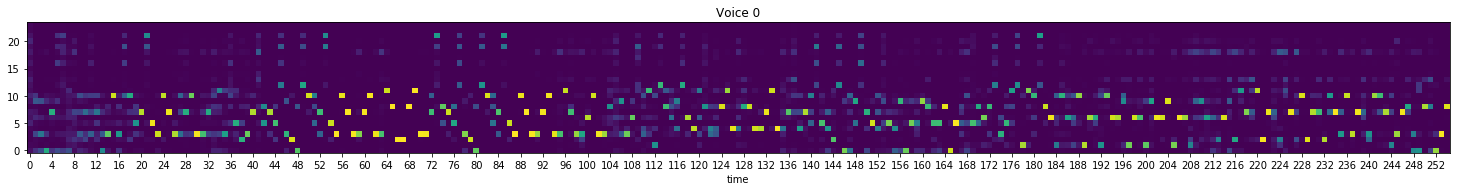

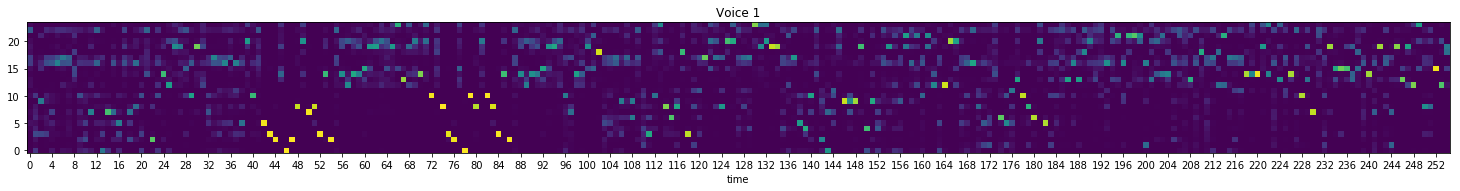

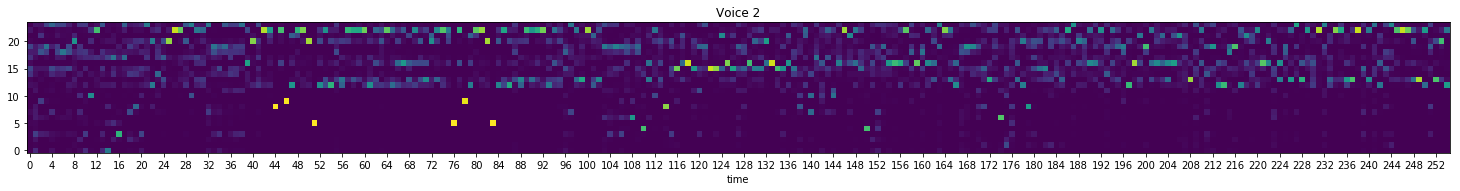

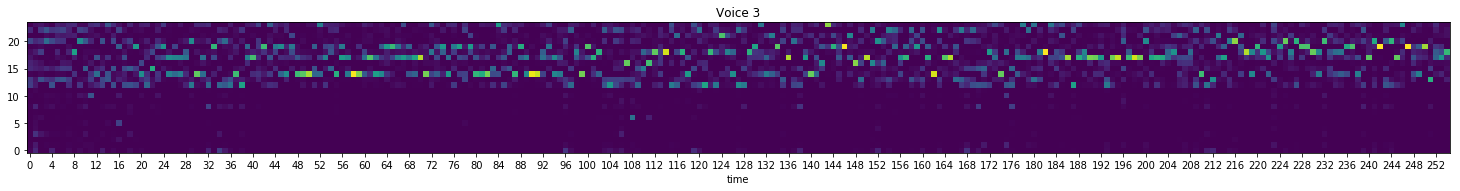

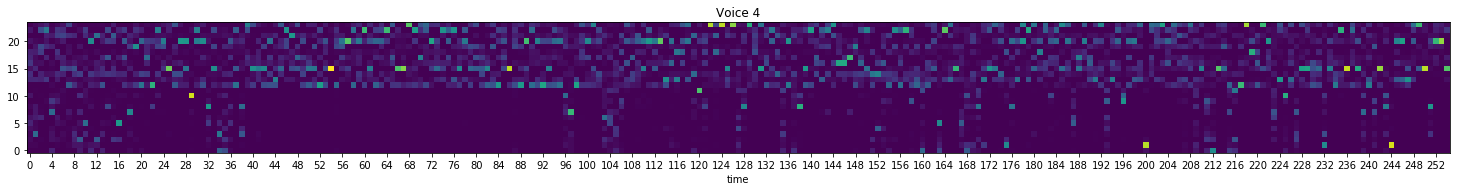

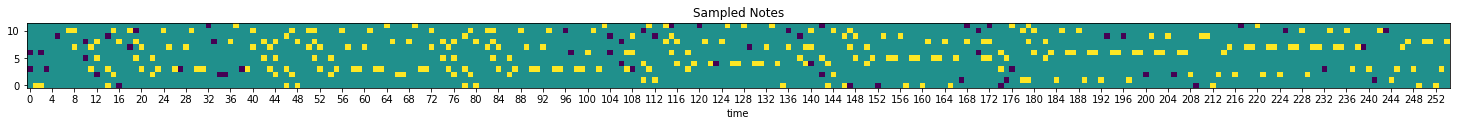

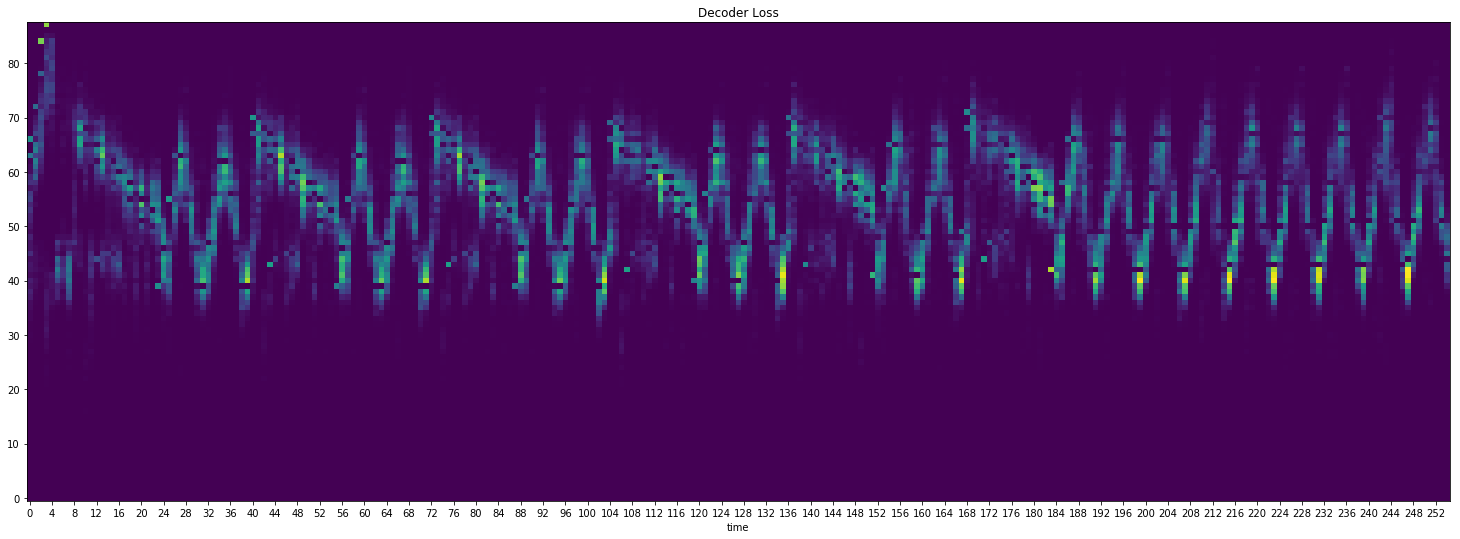

0.123975  mean for last:  0.128481


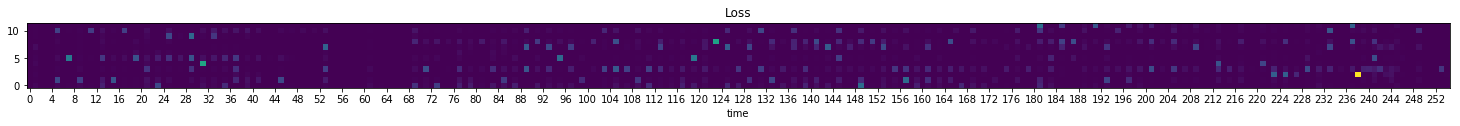

0.127295  mean for last:  0.128993


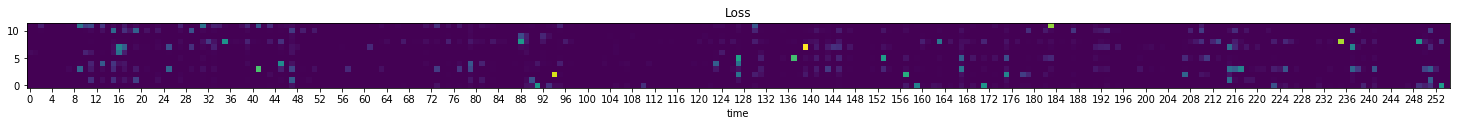

0.129727  mean for last:  0.128098


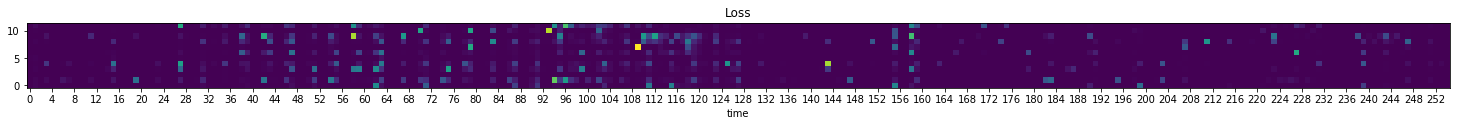

0.138349  mean for last:  0.12908


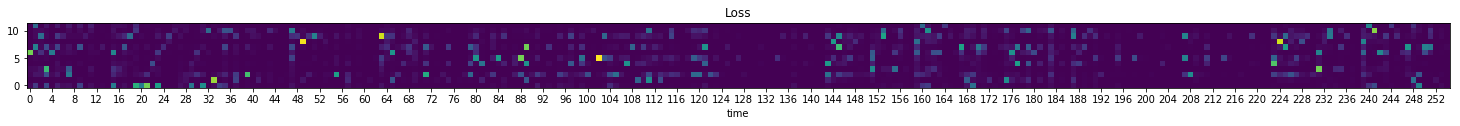

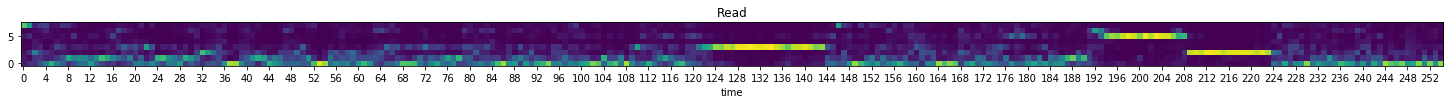

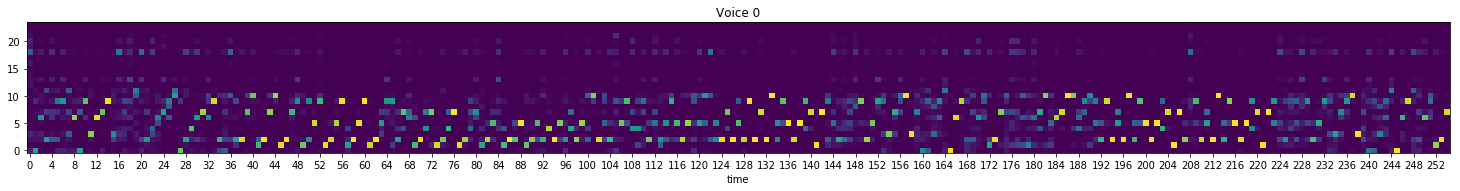

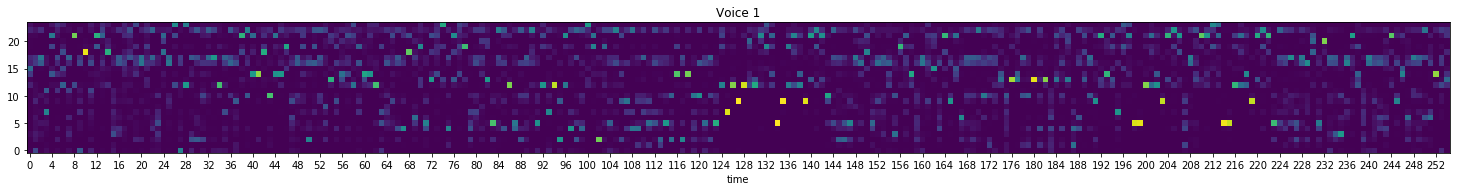

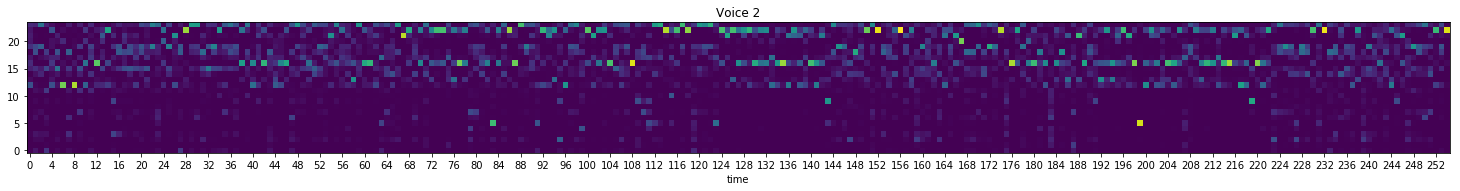

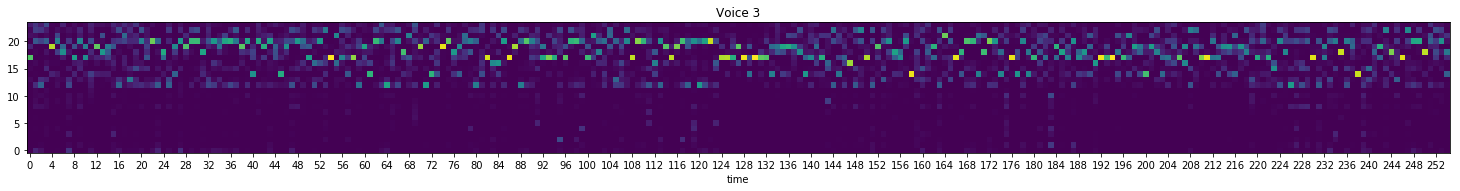

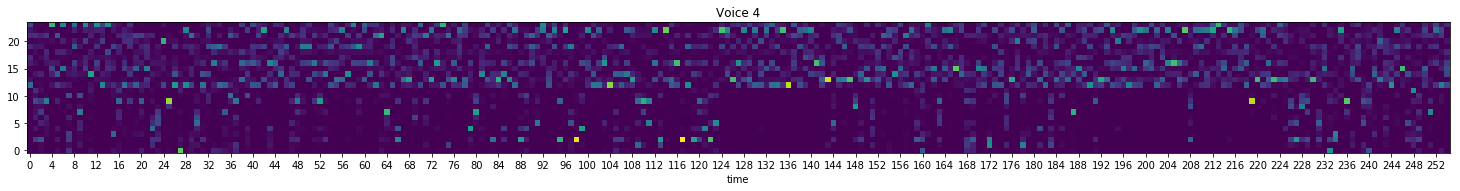

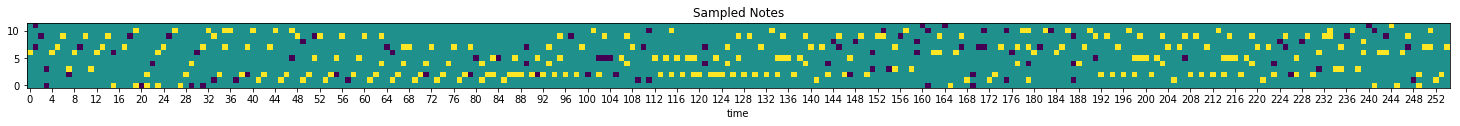

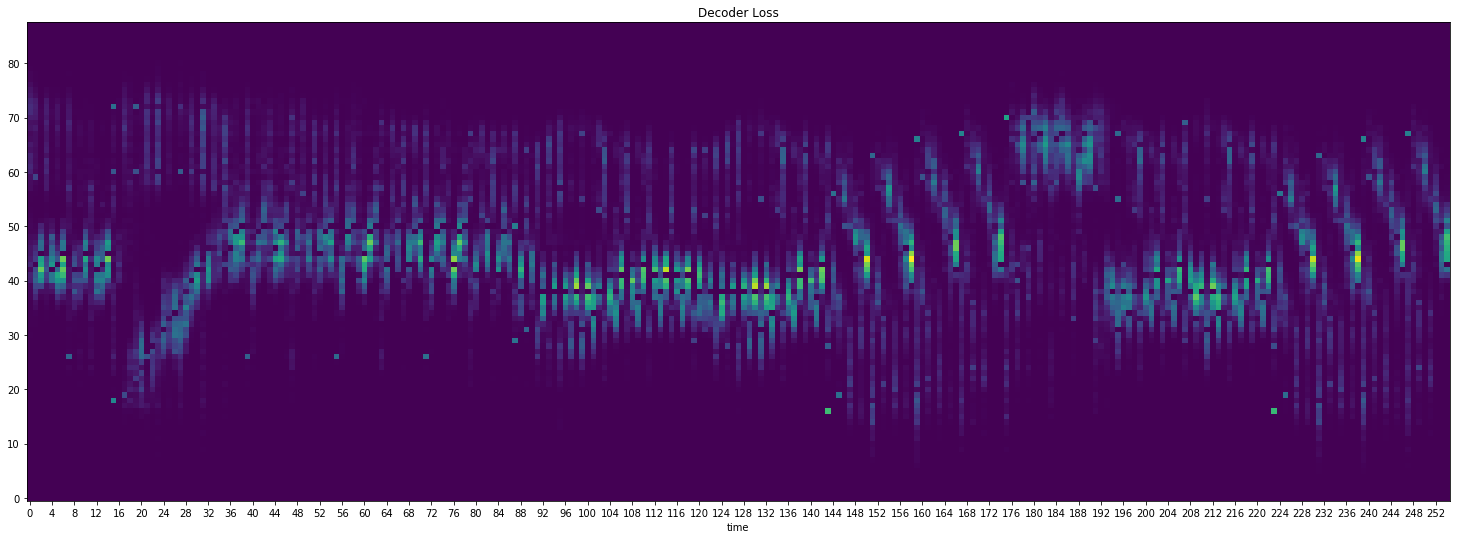

0.12938  mean for last:  0.128198


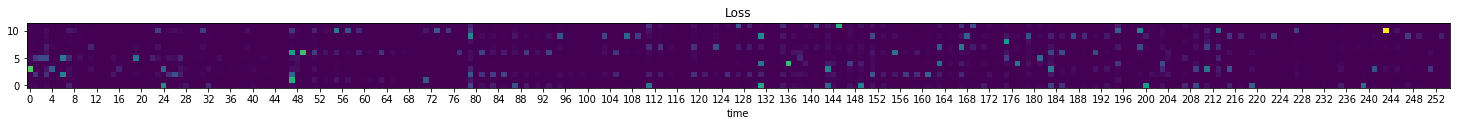

0.132126  mean for last:  0.128892


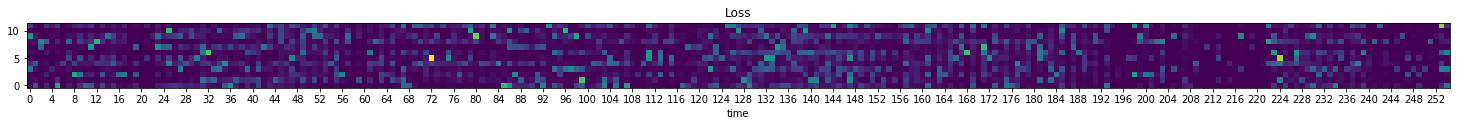

0.124988  mean for last:  0.126675


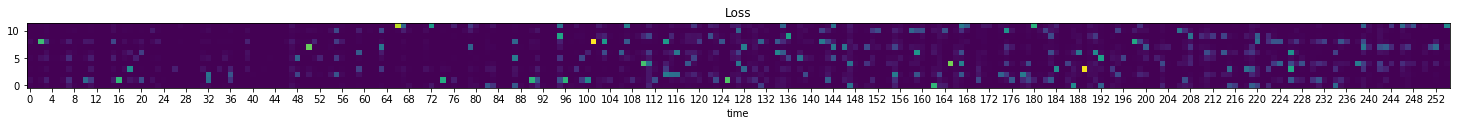

0.134253  mean for last:  0.126393


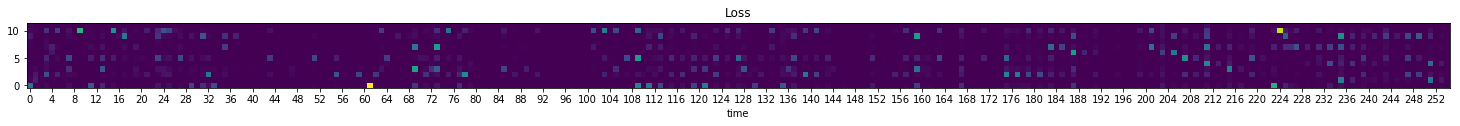

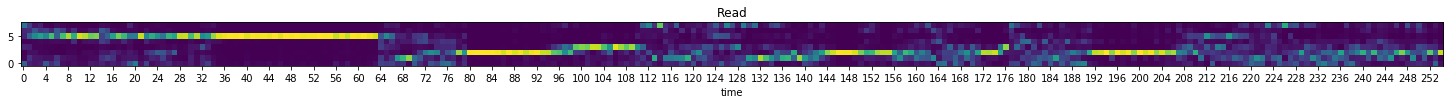

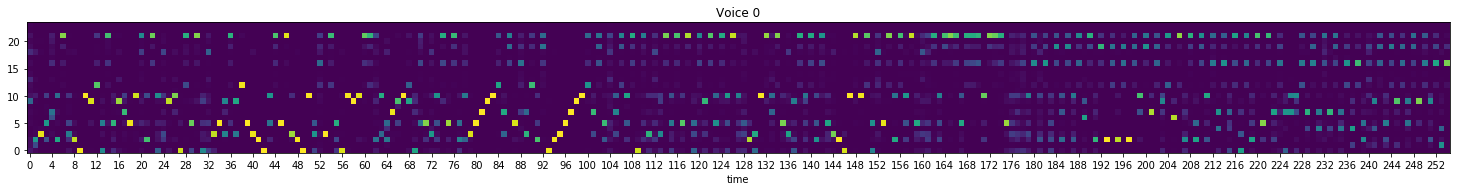

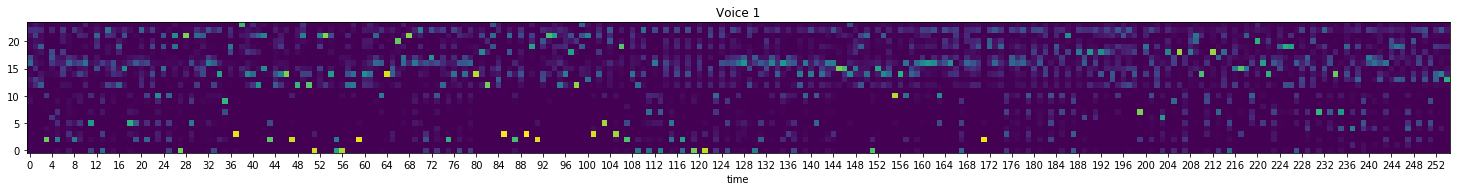

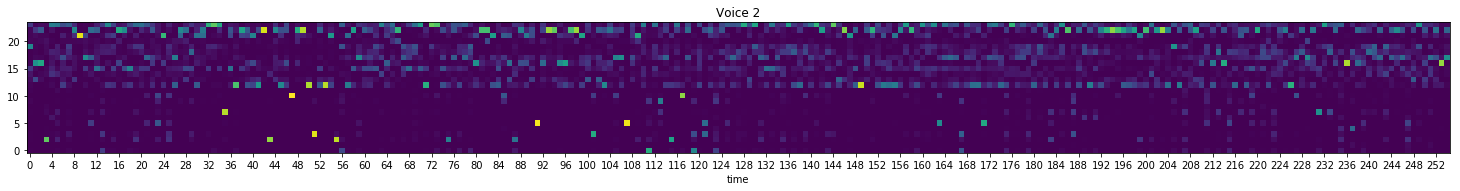

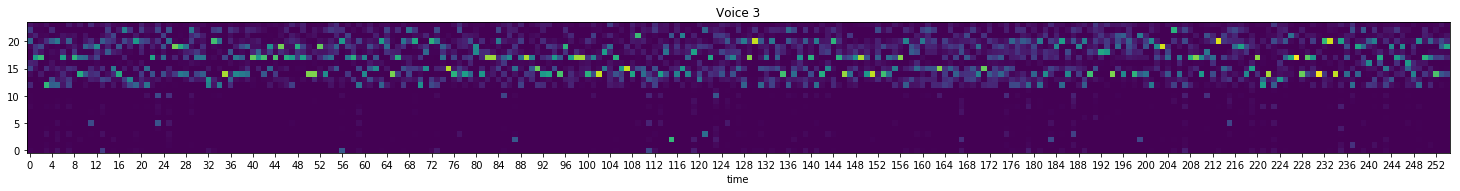

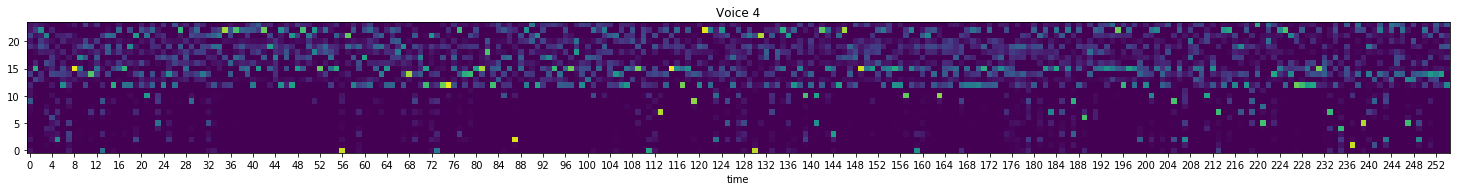

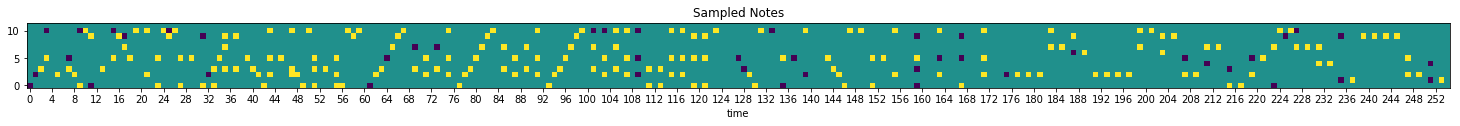

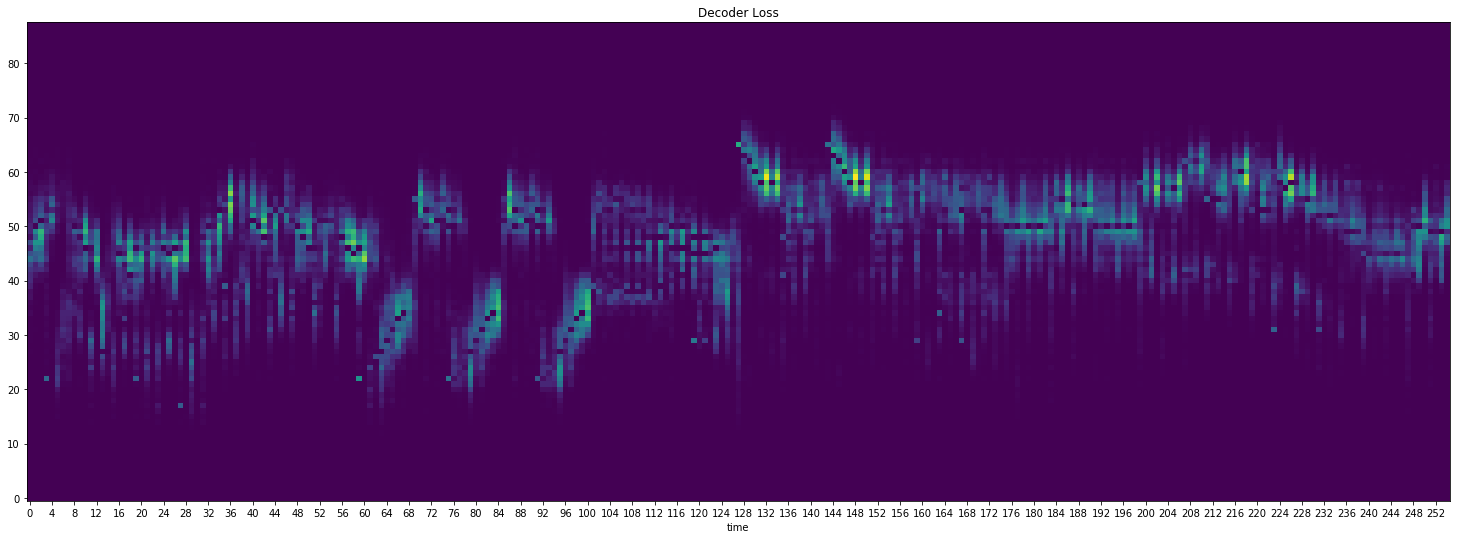

0.13534  mean for last:  0.128809


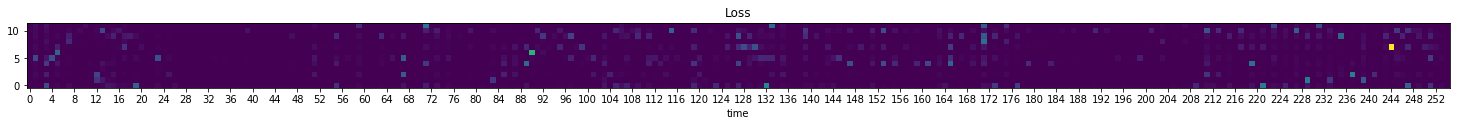

0.12526  mean for last:  0.127111


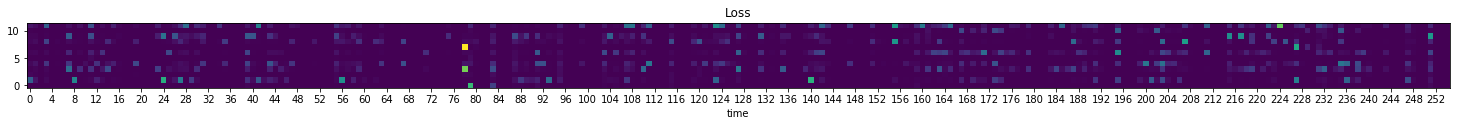

0.130779  mean for last:  0.128174


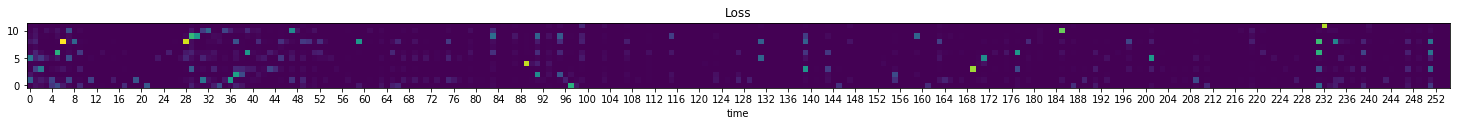

0.12303  mean for last:  0.126966


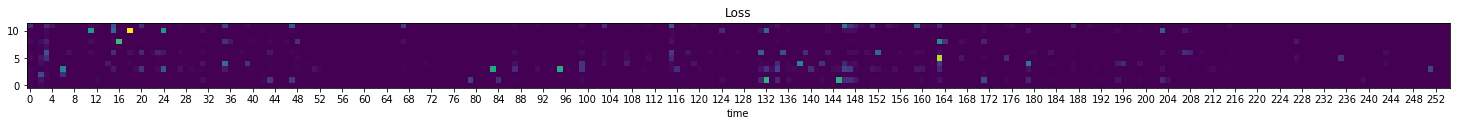

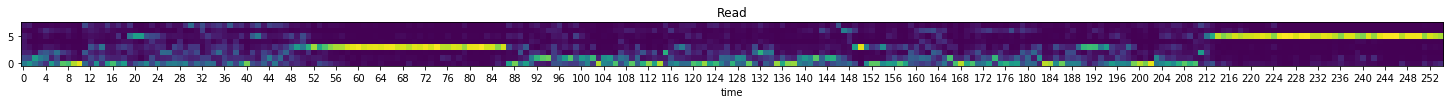

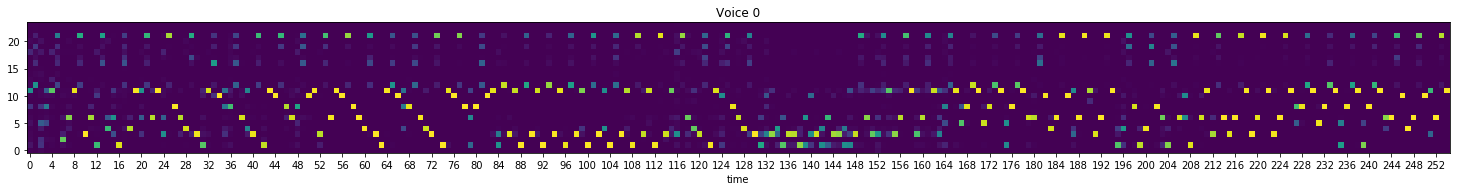

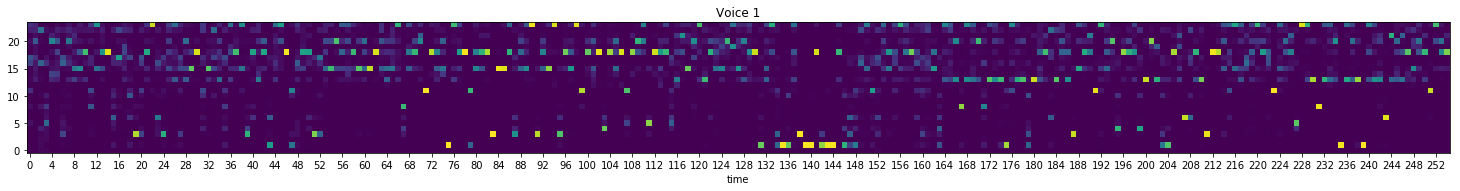

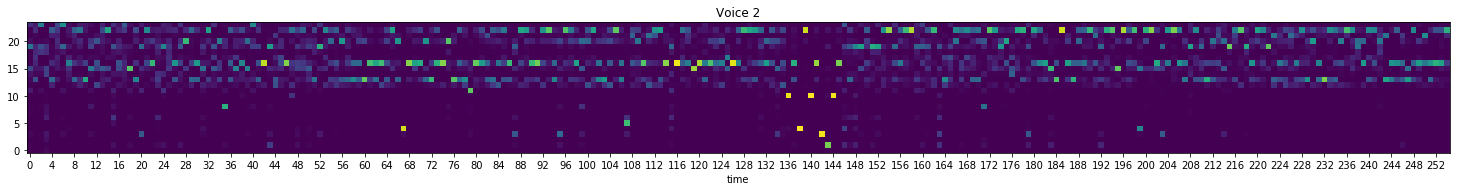

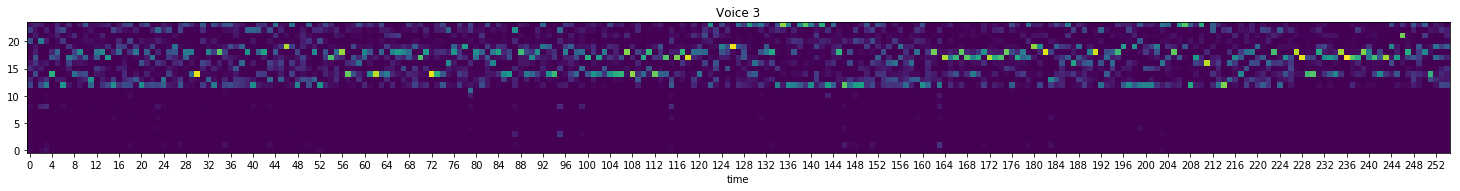

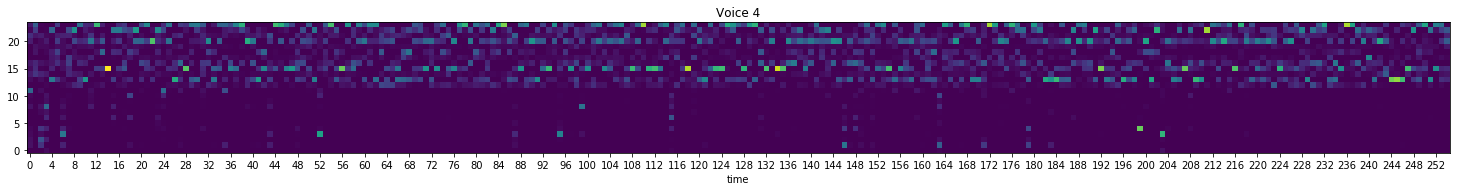

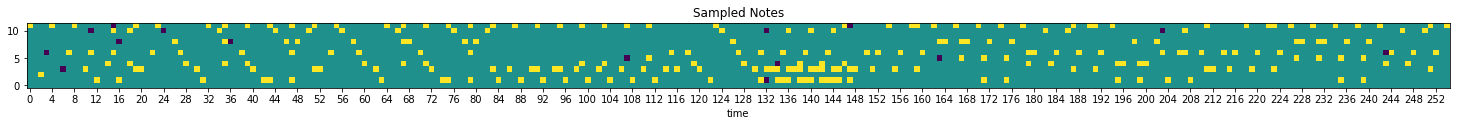

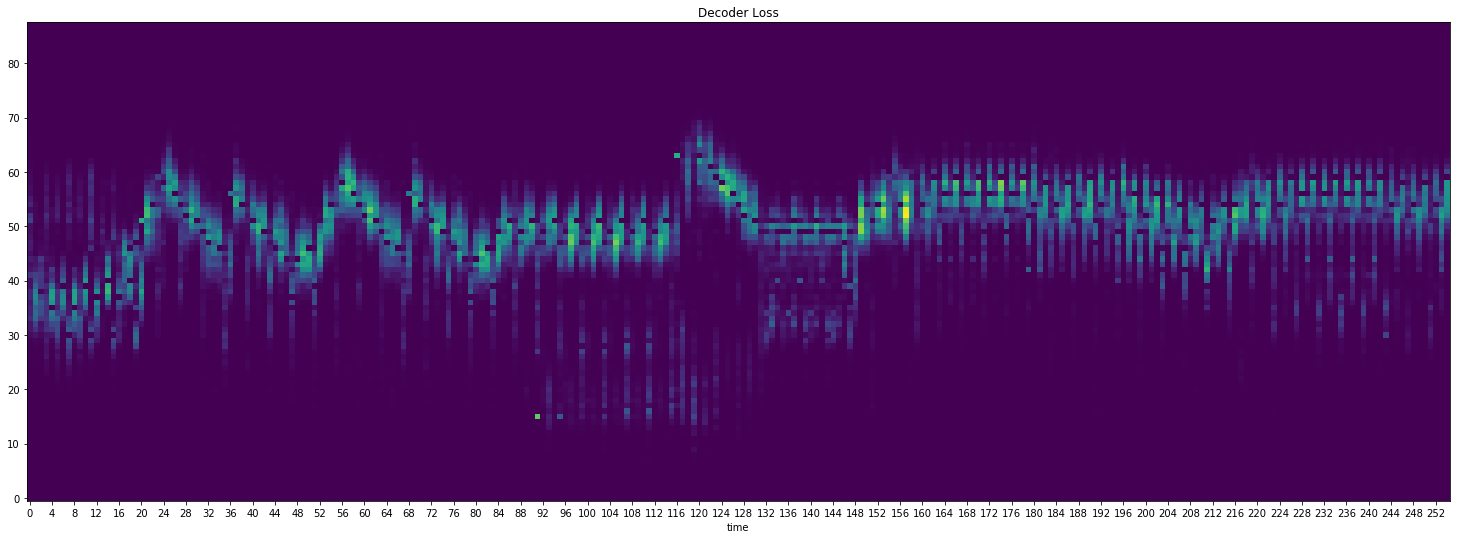

0.136193  mean for last:  0.128567


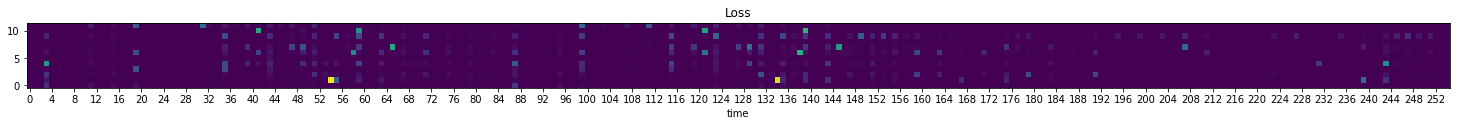

0.132064  mean for last:  0.127301


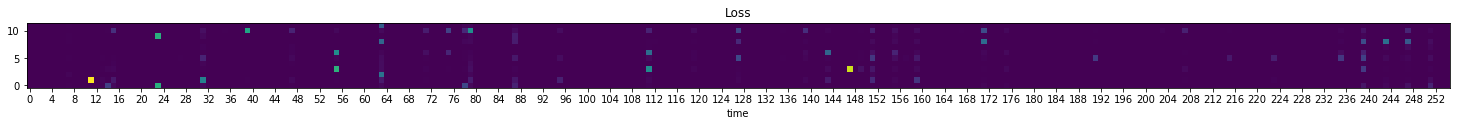

0.123769  mean for last:  0.12521


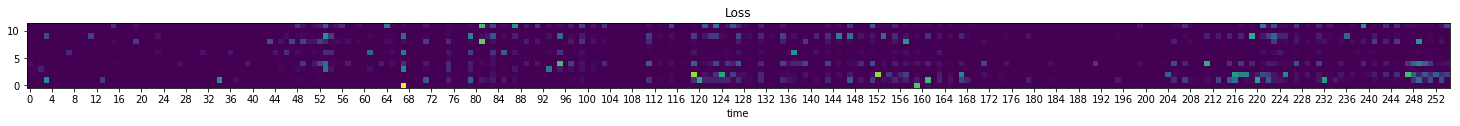

0.138331  mean for last:  0.12696


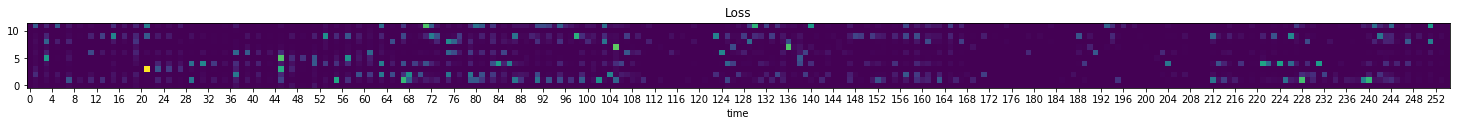

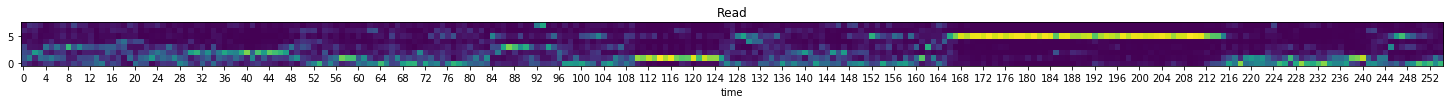

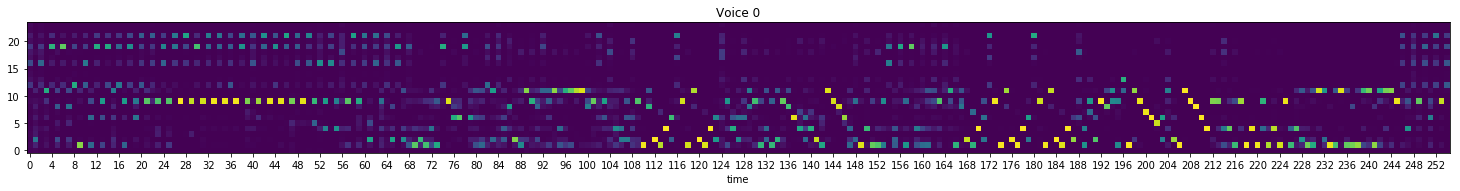

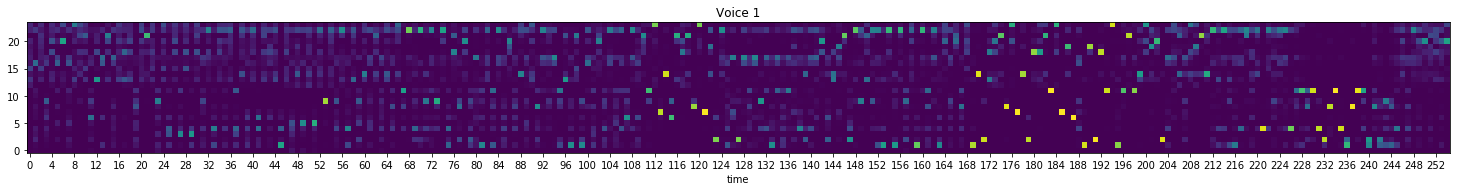

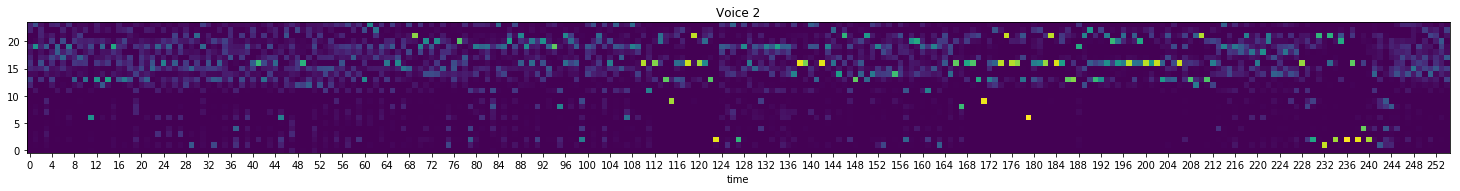

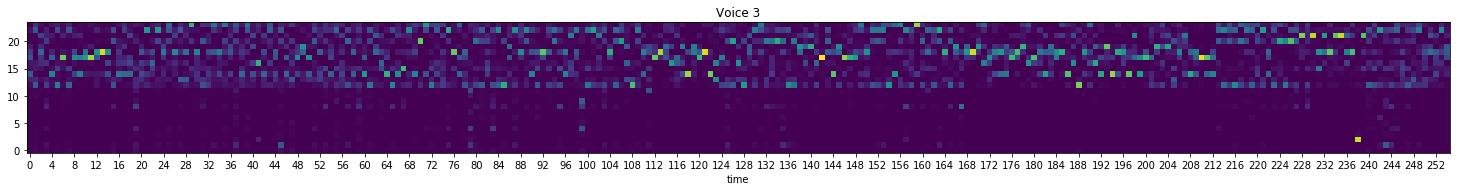

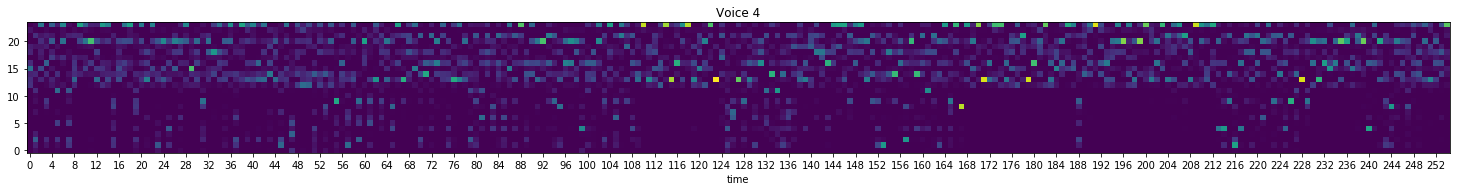

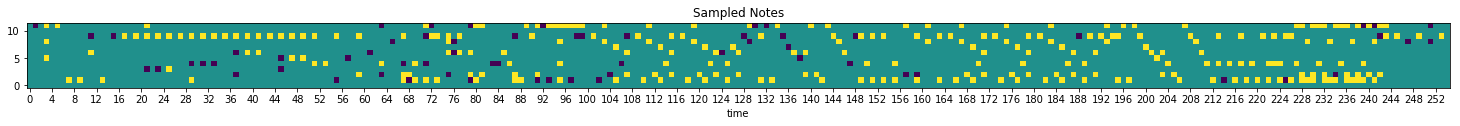

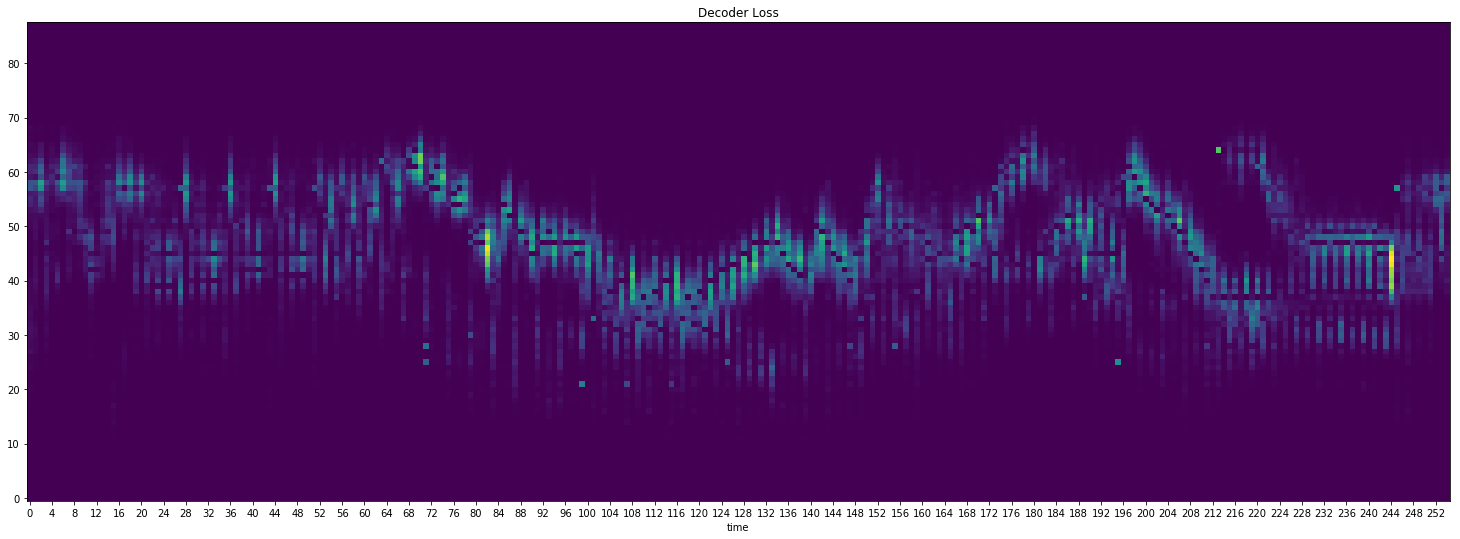

0.131495  mean for last:  0.12695


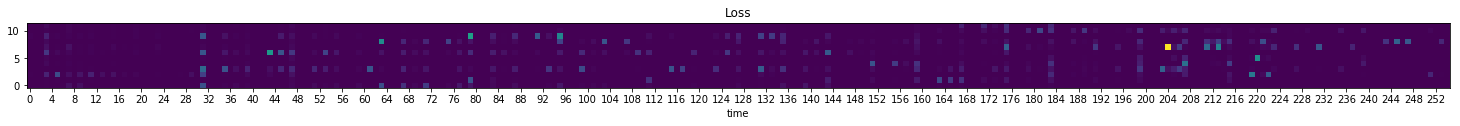

0.123912  mean for last:  0.127204


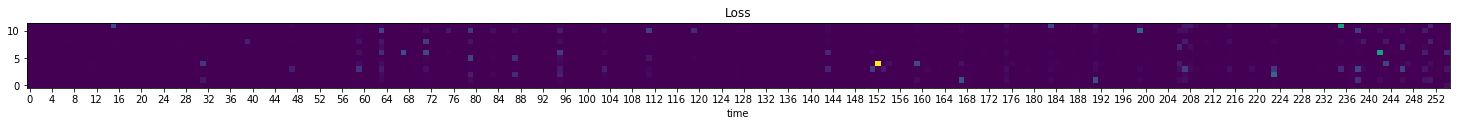

0.121543  mean for last:  0.125477


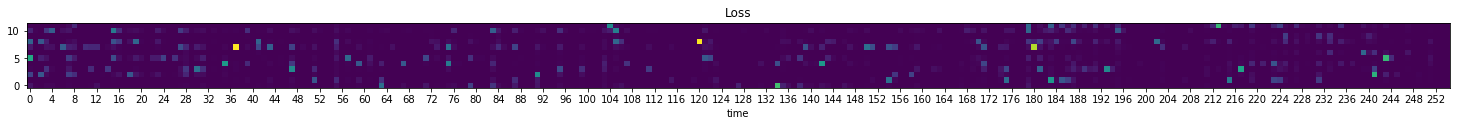

0.128529  mean for last:  0.126779


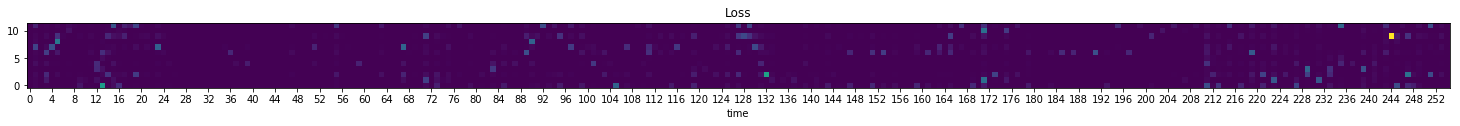

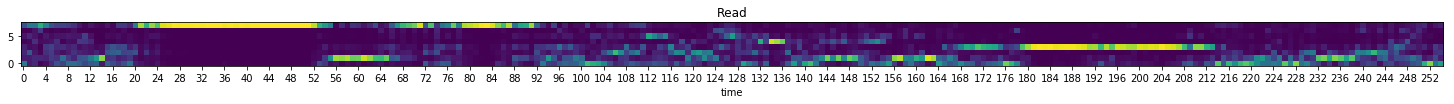

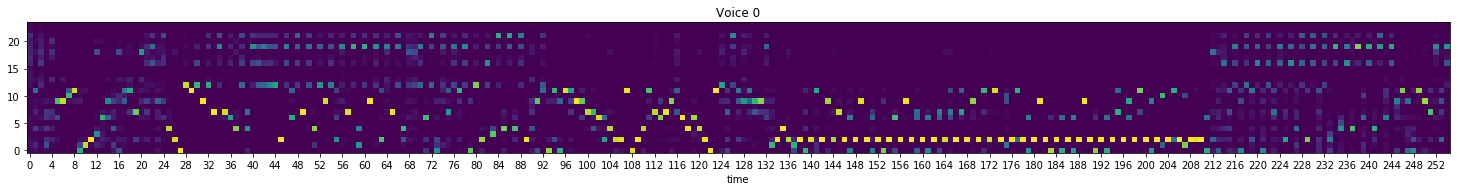

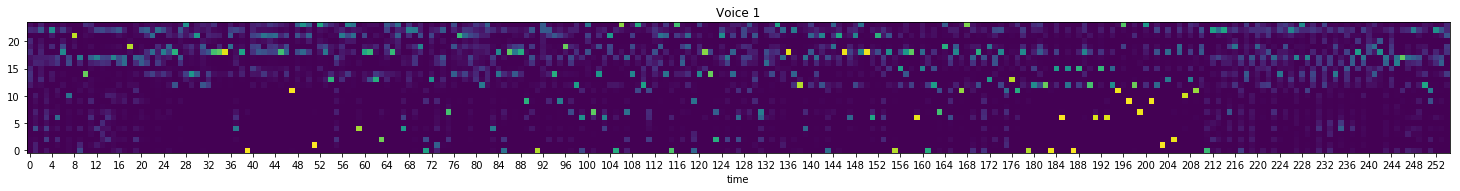

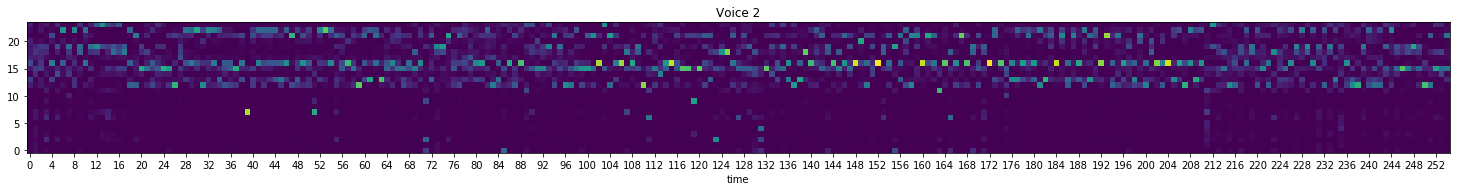

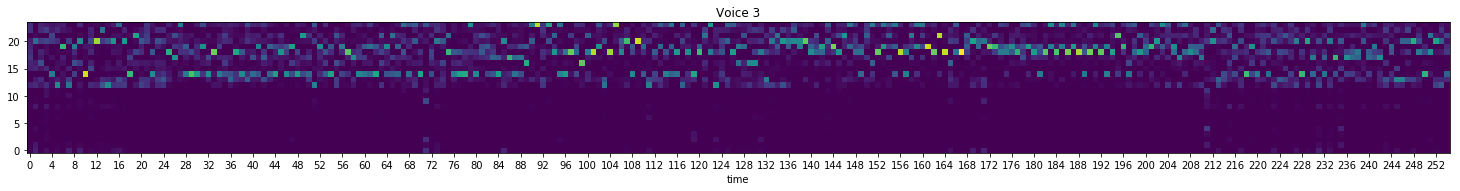

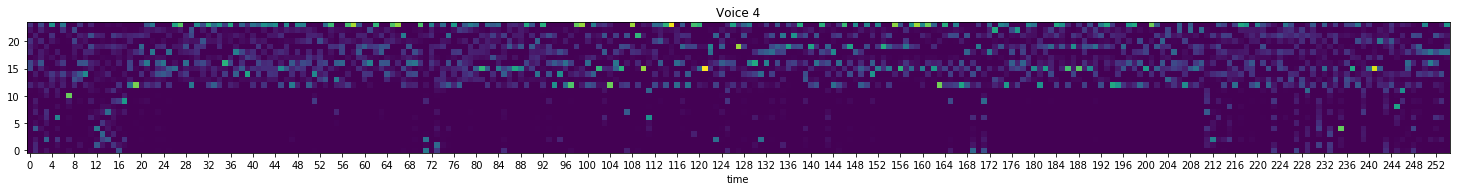

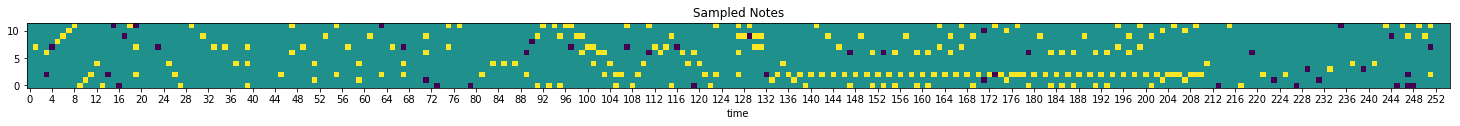

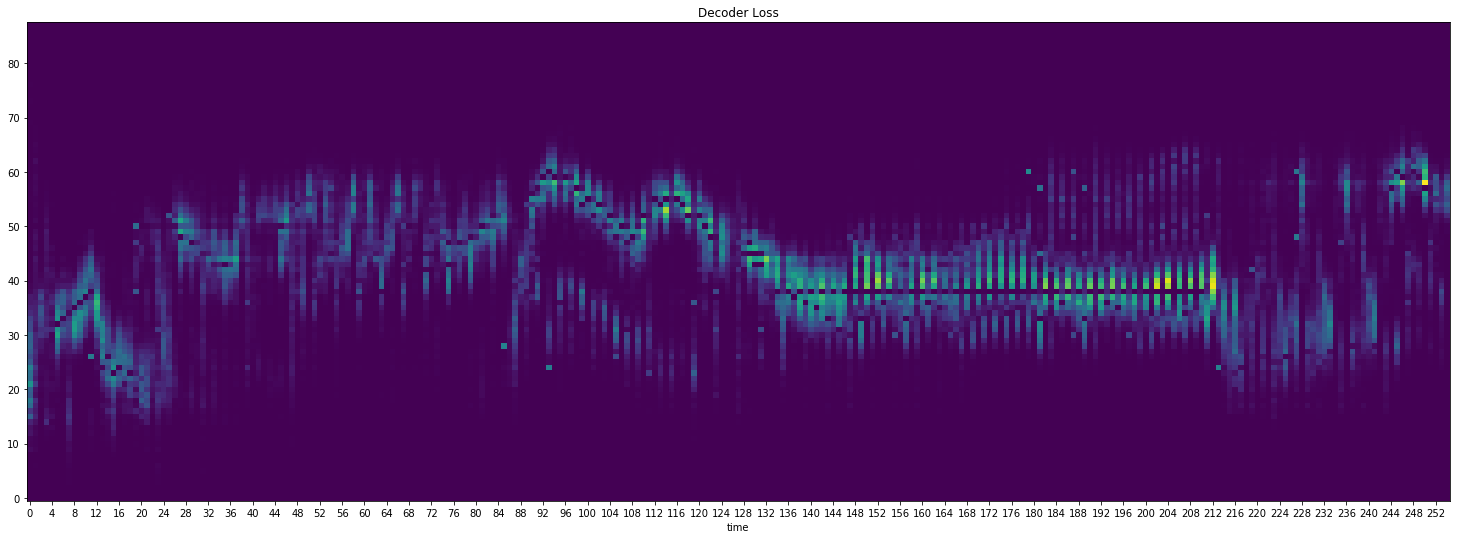

0.122767  mean for last:  0.128103


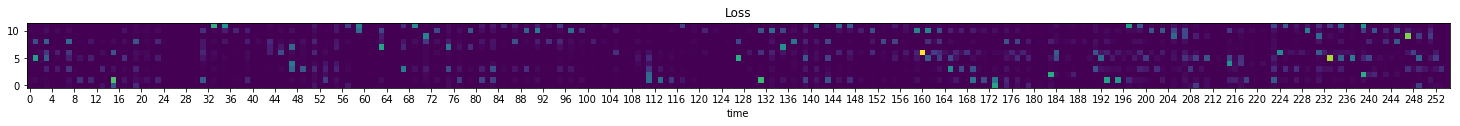

0.112872  mean for last:  0.125247


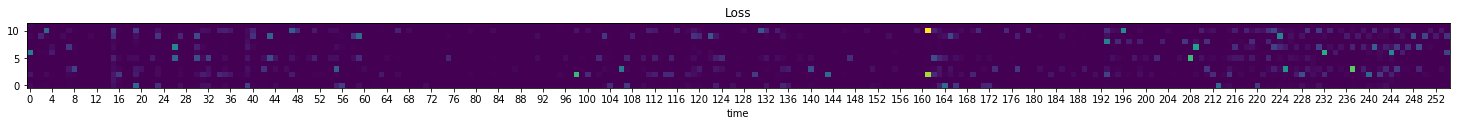

0.123375  mean for last:  0.126037


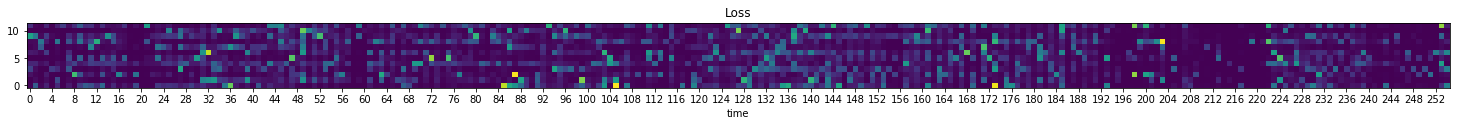

0.127014  mean for last:  0.127294


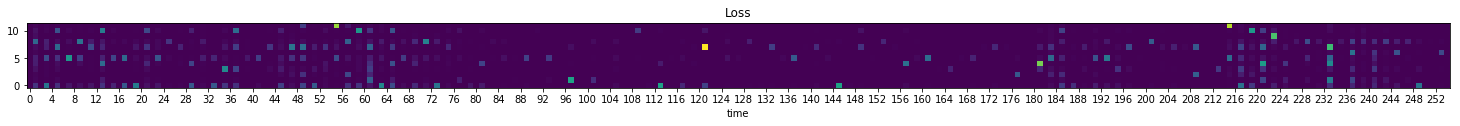

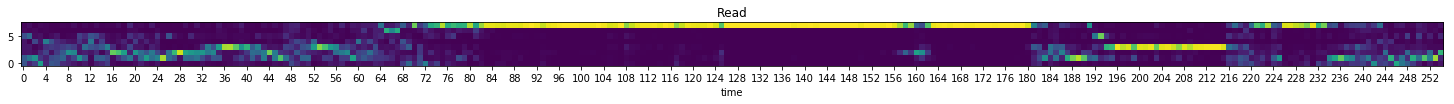

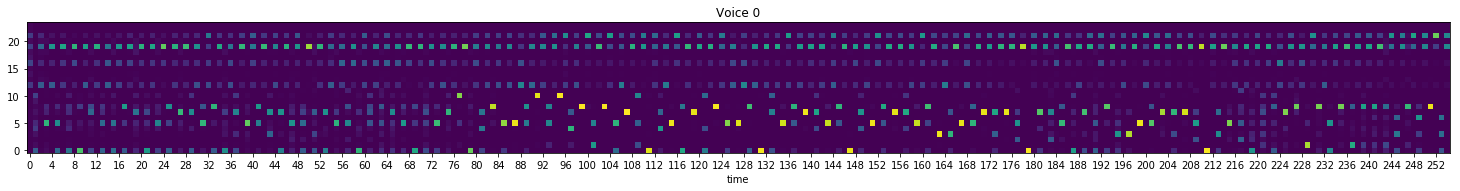

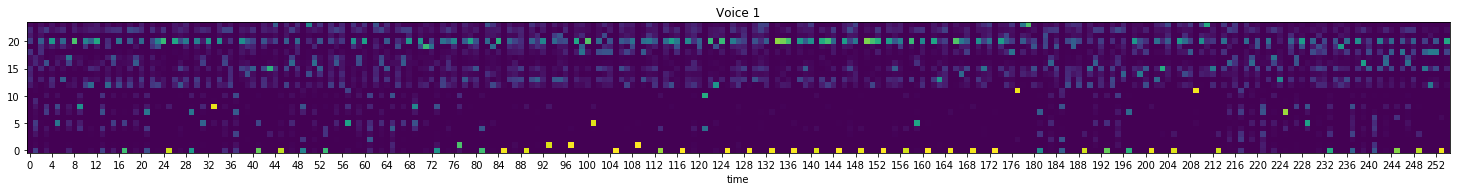

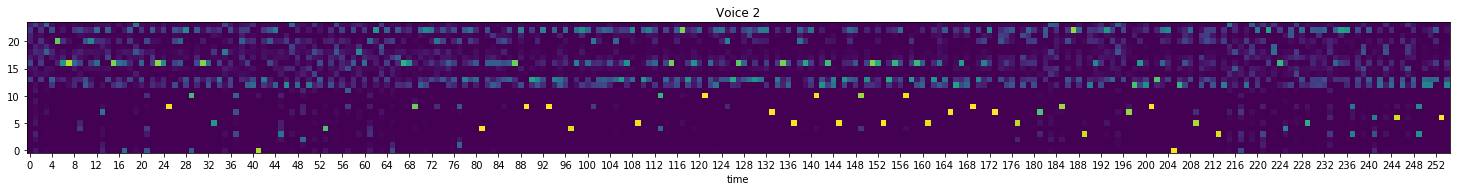

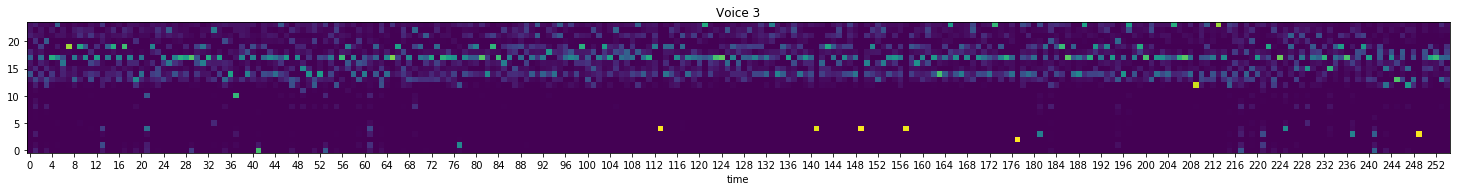

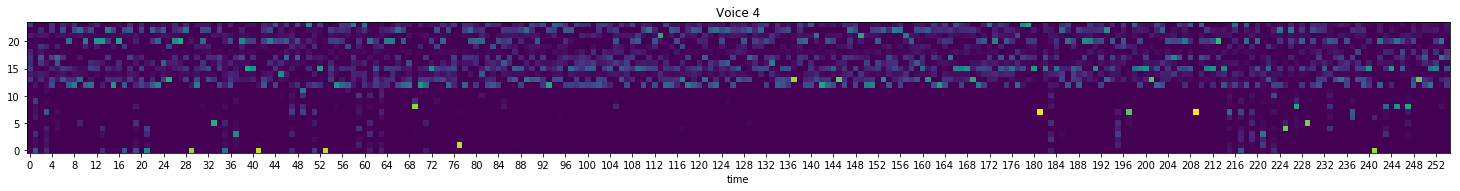

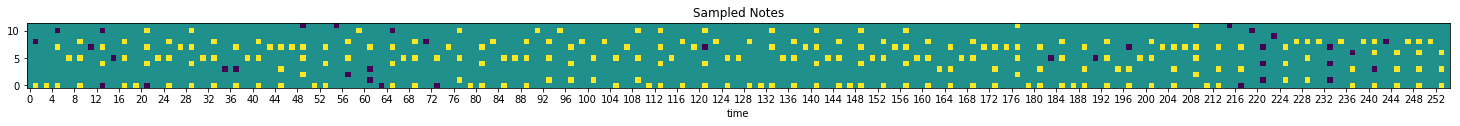

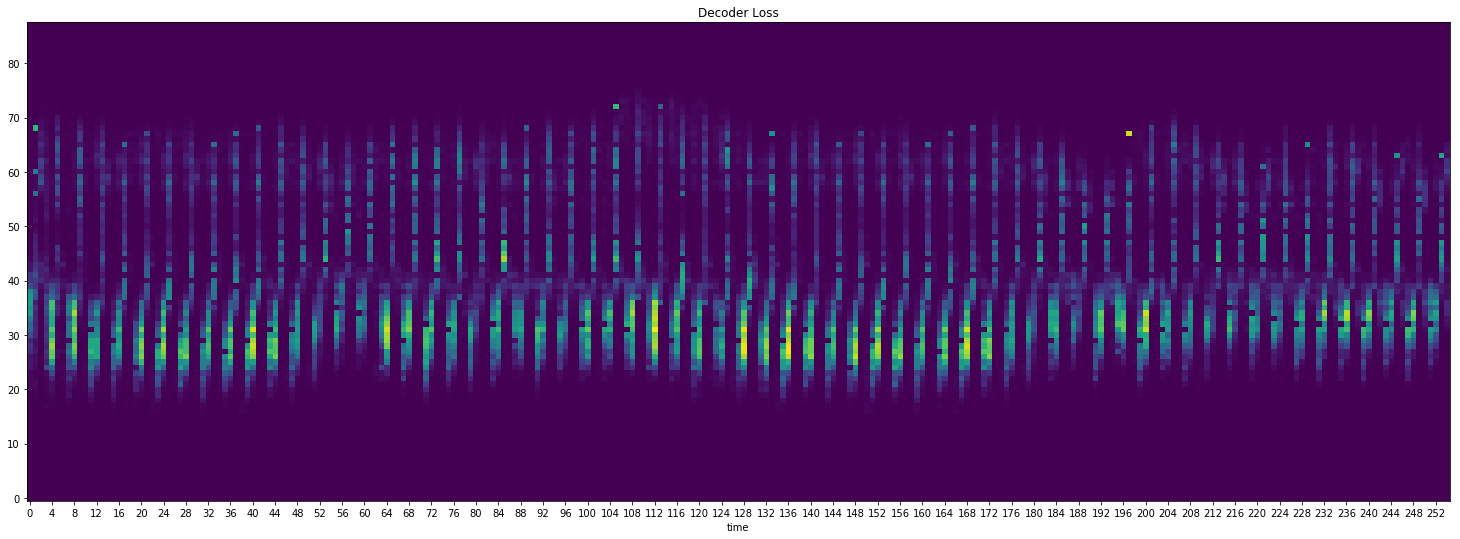

0.126941  mean for last:  0.126238


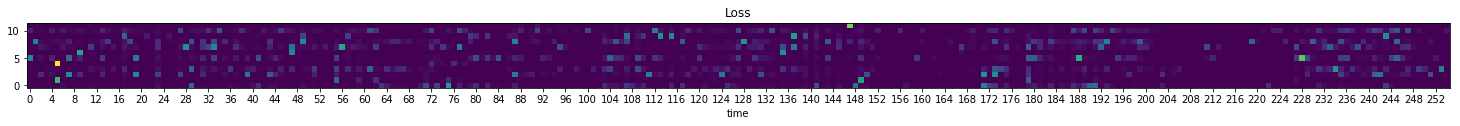

0.120023  mean for last:  0.126029


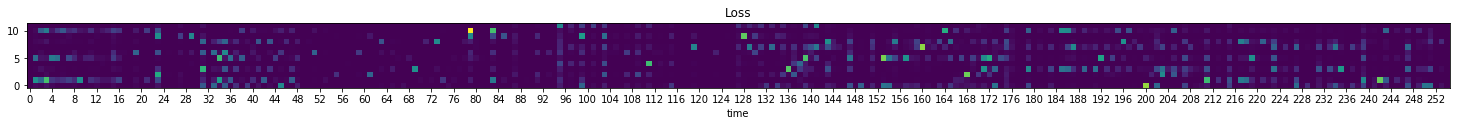

KeyboardInterrupt: 

In [49]:
training_steps = 200000
display_step = 50

#RECORD = 10

#losses = []
for step in range(training_steps + 1):
    # getting data
    batch_x, batch_h, batch_d = generateBatch()
    # Run optimization step
    fd = {X: batch_x, History: batch_h, was_sampled_notes_given: False, DecodedX: batch_d}
    _, L = sess.run([train_op, ce], feed_dict=fd)
    losses.append(L.mean())
    
    if np.isnan(L).any():
        print(" DAMN NAN ERROR")
        break
        
    if step % display_step == 0:
        print(L.mean(), " mean for last: ", np.array(losses)[-display_step:].mean())
        drawNotes(L[0], "Loss")
        
        if step % 200 == 0:
            r = sess.run(read_index, feed_dict=fd)
            drawNotes(r[0], "Read")
            
            sn = sess.run(voices_proba, feed_dict=fd)
            for i in range(5):
                drawNotes(sn[i][0], "Voice " + str(i))
            
            sn = sess.run(sampled_notes, feed_dict=fd)
            drawNotes(sn[0] - batch_x[0, 1:, :12]*(1-sn[0]), "Sampled Notes")
                
            sn = sess.run(decoder_ce, feed_dict=fd)
            drawNotes(sn[0], "Decoder Loss")
           
    if len(losses) > display_step and np.array(losses)[-display_step:].mean() < RECORD:
        RECORD = np.array(losses)[-display_step:].mean()
        saver.save(sess, "./tmp/100-100-100 HistoryUserScheme HAI LSTM collapsed CP_dataset 8-history 6-times 100-LSTMconditional banning no aposter 100-decoder lr=0.01.ckpt")
        
print("Optimization Finished!")

0.124769


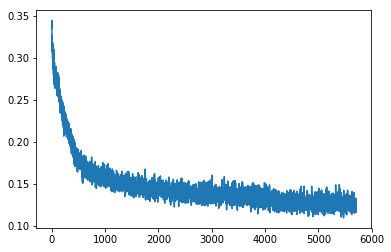

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

print(RECORD)
plt.plot(losses)  #collapsed trans 100-100-100 40LSTM-condition

In [51]:
import mido
from mido import MidiFile
import numpy as np
import copy
import math

import matplotlib.pyplot as plt
%matplotlib inline

# для возможности прослушивания midi прямо в ноутбуке
HEARING_PORT = mido.open_output()
# для вывода массивов numpy целиком
np.set_printoptions(threshold=np.nan)

BASE_NOTE = 21
KEYS = 88
FREQ = 4  #ticks for beat

def drawSong(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.notes.shape[0] / 10, song.notes.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(song.name)
    plt.imshow(song.notes.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.notes.shape[0], 4))
    plt.show()

# Класс для создания нового миди файла
class MySong:
    def __init__(self, played_lines=[], finished=False):
        self.name = "Generated song!"
        self.notes = np.zeros((0, 88))

        self.mid = MidiFile(type=0)
        self.track = mido.MidiTrack()
        self.mid.tracks.append(self.track)

        self.time_passed = 0
        self.release = []

        for line in played_lines:
            self.add(line)
           
        if finished:
            self.finish()

    # добавление новых строк в ноты
    def add(self, played):
        self.notes = np.vstack([self.notes, played])

        # "отпуск" нот, сыгранных долю назад
        if played.sum() > 0:
            for i in self.release:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=0, time=self.time_passed))
                self.time_passed = 0
            self.release = []

        # добавление новых нот
        for i, key in enumerate(played):
            if key == 1:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
                self.time_passed = 0
                self.release.append(i)
        self.time_passed += self.mid.ticks_per_beat // FREQ

    # должна быть вызвана в конце создания файла
    def finish(self):
        for i in self.release:
            self.track.append(mido.Message('note_off', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.track.append(mido.Message('note_off', note=BASE_NOTE, velocity=0, time=self.time_passed))

    # воспроизведение
    def play(self):
        for msg in self.mid.play():
            HEARING_PORT.send(msg)

    # сохранение
    def save_file(self, name):
        self.mid.save(name + '.mid')

OSError: MidiOutWinMM::openPort: error creating Windows MM MIDI output port.

In [52]:
def pers_transform(song, stack_zeros=True):    
    wh = song[:]
    
    temp = wh.copy()
    for t in HISTORY_TIMES:
        h = np.roll(temp, t, axis=0)
        h[:t] = 0
        wh = np.concatenate([wh, h], axis=1)
          
    wh = np.concatenate([wh, times[:song.shape[0]]], axis=1)
            
    return wh

In [53]:
def octave_sample(dec_p, all_sampled):
    ans = (np.random.uniform(0, 1, 88) < 1 / (1 + np.exp(-dec_p))) * np.tile(all_sampled, 8)[:88]
    for i, val in enumerate(all_sampled):
        if val == 1 and ans[i::12].sum() == 0:
             ans[i + dec_p[i::12].argmax()*12] = 1
    return ans

In [54]:
res = []

In [55]:
LR = 0.0

for s in range(5):
    song = songs[np.random.randint(0, 100)][:16]
    gen = transform(song)[:, :12]
    
    transd = pers_transform(gen)        
    t, h = np.hstack([transd[:, :12], transd[:, -ADDITIONAL_INPUT_SIZE:]]), transd[:, 12:-ADDITIONAL_INPUT_SIZE].reshape(-1, len(HISTORY_TIMES), 12) 
    
    tsn = np.array(sess.run(sampled_notes_by_voices, feed_dict={X: np.repeat(t[None], batch_size, axis=0), 
                                                       History: np.repeat(h[None], batch_size, axis=0),
                                                       was_sampled_notes_given: False}))[:, 0]

    while len(gen) < 512:
        gen = np.vstack([gen, 0.5*np.ones((12))])
        song = np.vstack([song, np.zeros((88))])

        transd = pers_transform(gen[-256:])
        t, h = np.hstack([transd[:, :12], transd[:, -ADDITIONAL_INPUT_SIZE:]]), transd[:, 12:-ADDITIONAL_INPUT_SIZE].reshape(-1, len(HISTORY_TIMES), 12)
        fd = {learning_rate: LR, X: np.repeat(t[None], batch_size, axis=0), History: np.repeat(h[None], batch_size, axis=0),
             was_sampled_notes_given: True, truly_sampled_notes: np.repeat(tsn[:, None, -254:], batch_size, axis=1),
             DecodedX: np.repeat(song[None, -256:], batch_size, axis=0)}
        sampled, dec_p, all_sampled = sess.run([sampled_notes_by_voices, decoder_p, sampled_notes], feed_dict=fd)
        
        tsn = np.concatenate([tsn, np.array(sampled)[:, 0, -1:]], axis=1)
        
        song[-1] = octave_sample(dec_p[0, -1], all_sampled[0, -1])
        gen[-1] = all_sampled[0, -1]
        
        print('|', end="")
    print("yeah!", s)
    res.append(song)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||yeah! 0
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [56]:
test = np.zeros((gen.shape[0], 88))
test[:, 42:54] = gen

ms = MySong(test, finished=True)

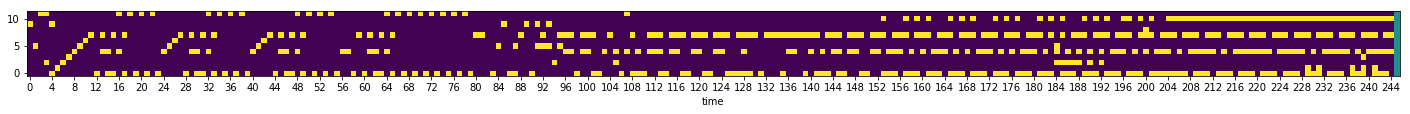

In [36]:
drawNotes(gen)

In [37]:
ms.play()

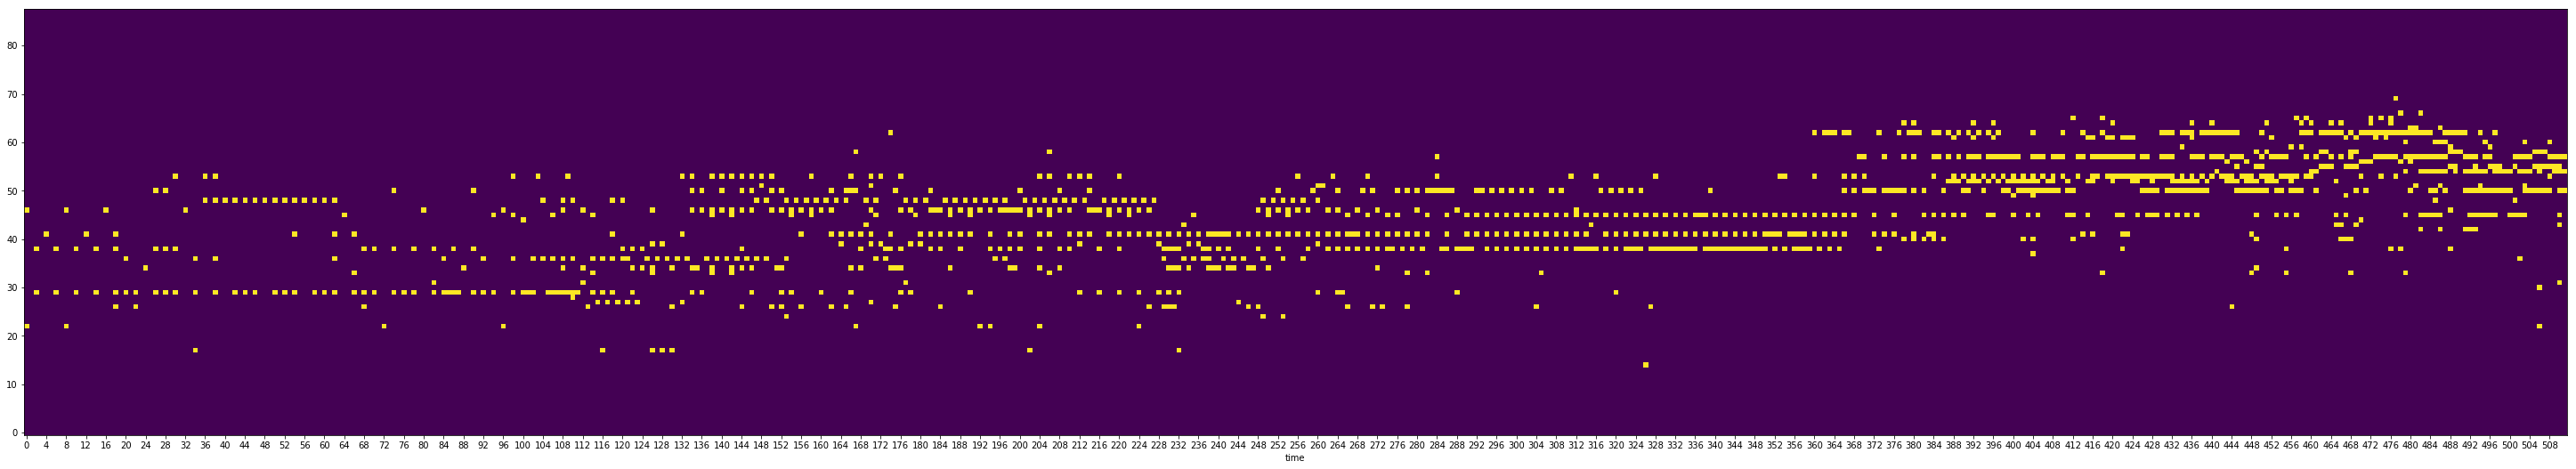

In [66]:
drawNotes(res[3])

In [67]:
ms = MySong(res[3], finished=True)

In [68]:
ms.play()

In [40]:
finale = np.zeros((0, 88))
for r in res:
    finale = np.vstack([finale, np.zeros((32, 88))])
    finale = np.vstack([finale, r[0:]])

In [41]:
finale.shape

(2176, 88)

In [42]:
finale = finale[:28760]

In [43]:
ms = MySong(finale, finished=True)

In [44]:
ms.save_file("banning pauses and HAI - CP dataset")